In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,precision_recall_curve
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, log_loss

from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE,ADASYN
from collections import Counter

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier

from IPython.display import Image  
from six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
 
import xgboost as xgb


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the csv file 
df0 = pd.read_csv('telecom_churn_data.csv', engine='python')

In [3]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [4]:
# checking the columns in the csv file 
print('No. of columns =',len(df0.columns))
df0.columns

No. of columns = 226


Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'sachet_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'],
      dtype='object', length=226)

In [5]:
#Finding null values 
df0.isnull().sum()[df0.isnull().sum()>1]

loc_og_t2o_mou           1018
std_og_t2o_mou           1018
loc_ic_t2o_mou           1018
last_date_of_month_7      601
last_date_of_month_8     1100
                        ...  
night_pck_user_9        74077
fb_user_6               74846
fb_user_7               74428
fb_user_8               73660
fb_user_9               74077
Length: 166, dtype: int64

In [6]:
# Total data recharge done per customer in the 6th month 
#  .fillna(0) used for changing null values to zero 
df0['total_data_rech_6'] = df0.total_rech_data_6.fillna(0) * df0.av_rech_amt_data_6.fillna(0)

In [7]:
# Total recharge done per customer in the 6th month = Data+Calling 
#  .fillna(0) used for changing null values to zero 
df0['rech_sum_6'] = df0['total_data_rech_6'] + df0.total_rech_amt_6.fillna(0)

In [8]:
# Total data recharge done per customer in the 7th month 
#  .fillna(0) used for changing null values to zero 
df0['total_data_rech_7'] = df0.total_rech_data_7.fillna(0) * df0.av_rech_amt_data_7.fillna(0)

In [9]:
# Total recharge done per customer in the 7th month = Data+Calling 
#  .fillna(0) used for changing null values to zero 
df0['rech_sum_7'] = df0['total_data_rech_7'] + df0.total_rech_amt_7.fillna(0)

In [10]:
#Average value of recharge done in the 'Good phase'
df0['avg_rech_good_phase'] = (df0['rech_sum_6']+df0['rech_sum_7'])/2

In [11]:
df0['avg_rech_good_phase']

0         559.0
1         306.0
2         241.5
3         270.0
4         301.0
          ...  
99994      85.0
99995     110.0
99996      98.5
99997    1602.0
99998     432.0
Name: avg_rech_good_phase, Length: 99999, dtype: float64

In [12]:
df0['avg_rech_good_phase'].quantile(q=0.7)

478.0

In [13]:
# Dataframe with high value customers 
df1 = df0[df0['avg_rech_good_phase']>df0['avg_rech_good_phase'].quantile(q=0.7)]

In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29953 entries, 0 to 99997
Columns: 231 entries, mobile_number to avg_rech_good_phase
dtypes: float64(184), int64(35), object(12)
memory usage: 53.0+ MB


total_ic_mou_9

total_og_mou_9

vol_2g_mb_9

vol_3g_mb_9

In [15]:
# Churn us when in the last month the customer hasnt done any incoming, outgoing or used any net 
# When the sum of all that is 0, the customer has churned 
df1['Churn'] = df1.total_ic_mou_9 + df1.total_og_mou_9 + df1.vol_2g_mb_9 + df1.vol_3g_mb_9

In [16]:
df1['Churn'][df1['Churn']==0]

0        0.0
7        0.0
67       0.0
86       0.0
111      0.0
        ... 
99827    0.0
99851    0.0
99868    0.0
99885    0.0
99887    0.0
Name: Churn, Length: 2433, dtype: float64

In [17]:
# Churn :1 , not churn : 0 
df1['Churn'] = df1['Churn'].apply(lambda x : 1 if x==0 else 0)

In [18]:
# Making a list of columns without 9th month at the end 
q = []
for i in range(len(list(df1.columns))):
    if list(df1.columns)[i][-1]!='9':
        q.append(list(df1.columns)[i])
q.remove('sep_vbc_3g')               

# The final data set to work on 

In [19]:
df = df1[q]

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29953 entries, 0 to 99997
Columns: 177 entries, mobile_number to Churn
dtypes: float64(140), int64(28), object(9)
memory usage: 40.7+ MB


In [21]:
df.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'arpu_6', 'arpu_7',
       ...
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'total_data_rech_6',
       'rech_sum_6', 'total_data_rech_7', 'rech_sum_7', 'avg_rech_good_phase',
       'Churn'],
      dtype='object', length=177)

In [22]:
# The following columns have no variance thereby not useful for prediction 
w = list(df.nunique()[df.nunique()==1].index)
w

['circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8']

In [23]:
# Dropping the un-necessary columns
df = df.drop(labels = w, axis=1)

In [24]:
# Finding all the values with null values >0
df.isnull().sum()[df.isnull().sum() >0]

onnet_mou_6           542
onnet_mou_7           536
onnet_mou_8          1172
offnet_mou_6          542
offnet_mou_7          536
                    ...  
night_pck_user_7    12915
night_pck_user_8    14018
fb_user_6           13213
fb_user_7           12915
fb_user_8           14018
Length: 114, dtype: int64

In [25]:
# Since 'mou = Minutes of usage - voice calls', the null values can be taken as 0
# For finding the rest of values without mou 
qw=[]
for i in range(len(df.columns)):
    if df.columns[i][-5:-2]!='mou':
        qw.append(df.columns[i])


In [26]:
# Columns with null values to impute
df[qw].isnull().sum()[df[qw].isnull().sum()>0]

og_others_6                   542
og_others_7                   536
og_others_8                  1172
ic_others_6                   542
ic_others_7                   536
ic_others_8                  1172
date_of_last_rech_6            73
date_of_last_rech_7            98
date_of_last_rech_8           582
date_of_last_rech_data_6    13213
date_of_last_rech_data_7    12915
date_of_last_rech_data_8    14018
total_rech_data_6           13213
total_rech_data_7           12915
total_rech_data_8           14018
max_rech_data_6             13213
max_rech_data_7             12915
max_rech_data_8             14018
count_rech_2g_6             13213
count_rech_2g_7             12915
count_rech_2g_8             14018
count_rech_3g_6             13213
count_rech_3g_7             12915
count_rech_3g_8             14018
av_rech_amt_data_6          13213
av_rech_amt_data_7          12915
av_rech_amt_data_8          14018
arpu_3g_6                   13213
arpu_3g_7                   12915
arpu_3g_8     

In [27]:
qa=[]
for i in range(len(df.columns)):
    if df.columns[i][:4]=='date':
        qa.append(df.columns[i])

In [28]:
#Dropping columns with date values 
df = df.drop(qa,axis=1)

In [29]:
#Imputing the missing values as 0 
df = df.fillna(0)

In [30]:
# Finding all the values with null values >0
df.isnull().sum()[df.isnull().sum() >0]

Series([], dtype: int64)

# EDA

In [31]:
from matplotlib.pyplot import figure

In [33]:
df.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_data_rech_6,rech_sum_6,total_data_rech_7,rech_sum_7,avg_rech_good_phase,Churn
0,7000842753,197.385,214.816,213.803,0.00,0.00,0.00,0.00,0.00,0.00,...,968,30.40,0.00,101.20,252.0,614.0,252.0,504.0,559.0,1
7,7000701601,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,...,802,57.74,19.38,18.74,0.0,1580.0,0.0,790.0,1185.0,1
8,7001524846,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,...,315,21.03,910.65,122.16,0.0,437.0,354.0,955.0,696.0,0
21,7002124215,514.453,597.753,637.760,102.41,132.11,85.14,757.93,896.68,983.39,...,720,0.00,0.00,0.00,0.0,600.0,0.0,680.0,640.0,0
23,7000887461,74.350,193.897,366.966,48.96,50.66,33.58,85.41,89.36,205.89,...,604,40.45,51.86,0.00,0.0,0.0,712.0,1166.0,583.0,0


In [34]:
len(df.columns)

158

In [35]:
eda = df.copy()

In [36]:
df.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_data_rech_6,rech_sum_6,total_data_rech_7,rech_sum_7,avg_rech_good_phase,Churn
0,7000842753,197.385,214.816,213.803,0.00,0.00,0.00,0.00,0.00,0.00,...,968,30.40,0.00,101.20,252.0,614.0,252.0,504.0,559.0,1
7,7000701601,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,...,802,57.74,19.38,18.74,0.0,1580.0,0.0,790.0,1185.0,1
8,7001524846,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,...,315,21.03,910.65,122.16,0.0,437.0,354.0,955.0,696.0,0
21,7002124215,514.453,597.753,637.760,102.41,132.11,85.14,757.93,896.68,983.39,...,720,0.00,0.00,0.00,0.0,600.0,0.0,680.0,640.0,0
23,7000887461,74.350,193.897,366.966,48.96,50.66,33.58,85.41,89.36,205.89,...,604,40.45,51.86,0.00,0.0,0.0,712.0,1166.0,583.0,0


Deriving variables for MOU : ratio of change in mou from good phase (6th and 7th month) to action phase (8th month)

In [37]:
def new_var(X):
    X_6 = X + '_6'
    X_7 = X + '_7'
    X_8 = X + '_8'
    eda[X] = ((eda[X_6] + eda[X_7]) - eda[X_8])/(eda[X_6] + eda[X_7])

In [38]:
cols = ['arpu','onnet_mou','offnet_mou','roam_ic_mou','roam_og_mou','loc_og_t2t_mou','loc_og_t2m_mou','loc_og_t2f_mou', 
        'loc_og_t2c_mou','loc_og_mou','std_og_t2t_mou','std_og_t2m_mou','std_og_t2f_mou','std_og_mou','isd_og_mou', 
        'spl_og_mou','og_others','total_og_mou','loc_ic_t2t_mou','loc_ic_t2m_mou','loc_ic_t2f_mou','loc_ic_mou', 
        'std_ic_t2t_mou','std_ic_t2m_mou','std_ic_t2f_mou','std_ic_mou','isd_ic_mou','spl_ic_mou','ic_others','total_ic_mou']

In [39]:
for col in cols:
    new_var(col)

In [40]:
eda['total_rech_num_good_phase'] = eda['total_rech_num_6'] + eda['total_rech_num_7']
#rech_num_action_phase = total_rech_num_8
eda['rech_num'] = (eda['total_rech_num_good_phase'] + eda['total_rech_num_8'])/eda['total_rech_num_good_phase']

In [41]:
new_var('total_rech_amt')
new_var('av_rech_amt_data')

In [42]:
eda.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,std_ic_t2f_mou,std_ic_mou,isd_ic_mou,spl_ic_mou,ic_others,total_ic_mou,total_rech_num_good_phase,rech_num,total_rech_amt,av_rech_amt_data
0,7000842753,197.385,214.816,213.803,0.00,0.00,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,-inf,7,1.285714,0.589577,0.500000
7,7000701601,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,...,0.743029,0.451558,-0.904159,1.0,0.510508,0.638041,10,1.700000,-0.535021,NaN
8,7001524846,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,...,NaN,0.972315,NaN,NaN,NaN,0.875028,40,1.350000,0.884393,0.610169
21,7002124215,514.453,597.753,637.760,102.41,132.11,85.14,757.93,896.68,983.39,...,NaN,0.190839,NaN,NaN,NaN,0.229925,48,1.562500,0.439063,NaN
23,7000887461,74.350,193.897,366.966,48.96,50.66,33.58,85.41,89.36,205.89,...,NaN,-2.213124,0.867517,NaN,-1.441121,0.128887,8,1.500000,0.033040,0.241573


list of new columns added : ['arpu','onnet_mou','offnet_mou','roam_ic_mou','roam_og_mou','loc_og_t2t_mou','loc_og_t2m_mou','loc_og_t2f_mou',
                            'loc_og_t2c_mou','loc_og_mou','std_og_t2t_mou','std_og_t2m_mou','std_og_t2f_mou','std_og_mou','isd_og_mou',
                            'spl_og_mou','og_others','total_og_mou','loc_ic_t2t_mou','loc_ic_t2m_mou','loc_ic_t2f_mou','loc_ic_mou',
                            'std_ic_t2t_mou','std_ic_t2m_mou','std_ic_t2f_mou','std_ic_mou','isd_ic_mou','spl_ic_mou','ic_others','total_ic_mou']

list of columns to be taken for boxplots - ['arpu','total_mou','total_roam_mou','total_og_mou','total_ic_mou','isd_og_mou','isd_ic_mou','spl_og_mou','spl_ic_mou',
'ic_others','og_others','total_rech_num_good_phase','total_rech_num_8','rech_num','total_rech_amt','av_rech_amt_data',
'aon','Churn']

In [43]:
eda1 = eda[['arpu','onnet_mou','offnet_mou','roam_ic_mou','roam_og_mou','loc_og_t2t_mou','loc_og_t2m_mou','loc_og_t2f_mou', 'loc_og_t2c_mou','loc_og_mou','std_og_t2t_mou','std_og_t2m_mou','std_og_t2f_mou','std_og_mou','isd_og_mou', 'spl_og_mou','og_others','total_og_mou','loc_ic_t2t_mou','loc_ic_t2m_mou','loc_ic_t2f_mou','loc_ic_mou', 'std_ic_t2t_mou','std_ic_t2m_mou','std_ic_t2f_mou','std_ic_mou','isd_ic_mou','spl_ic_mou','ic_others','total_ic_mou','avg_rech_good_phase','total_rech_num_good_phase','total_rech_num_8','rech_num','total_rech_amt','av_rech_amt_data','aon','Churn']]

In [44]:
eda1.head()

,arpu,onnet_mou,offnet_mou,roam_ic_mou,roam_og_mou,loc_og_t2t_mou,loc_og_t2m_mou,loc_og_t2f_mou,loc_og_t2c_mou,loc_og_mou,...,ic_others,total_ic_mou,avg_rech_good_phase,total_rech_num_good_phase,total_rech_num_8,rech_num,total_rech_amt,av_rech_amt_data,aon,Churn
0,0.481314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-inf,559.0,7,2,1.285714,0.589577,0.500000,968,1
7,-0.311054,0.535283,0.680665,0.363636,-0.047619,0.513350,0.785347,0.546090,NaN,0.732457,...,0.510508,0.638041,1185.0,10,7,1.700000,-0.535021,NaN,802,1
8,0.842284,0.954127,0.221405,NaN,NaN,0.975734,0.666491,NaN,-inf,0.905384,...,NaN,0.875028,696.0,40,14,1.350000,0.884393,0.610169,315,0
21,0.426581,0.636961,0.405667,NaN,NaN,-1.193609,0.416880,-1.106667,NaN,0.321195,...,NaN,0.229925,640.0,48,27,1.562500,0.439063,NaN,720,0
23,-0.368015,0.662919,-0.178063,NaN,NaN,0.662919,0.104791,NaN,-inf,0.314206,...,-1.441121,0.128887,583.0,8,4,1.500000,0.033040,0.241573,604,0


In [45]:
eda1['total_mou'] = eda1['onnet_mou'] + eda1['offnet_mou']

In [46]:
eda1['total_roam_mou'] = eda1['roam_ic_mou'] + eda1['roam_og_mou']

In [47]:
eda1 = eda1.reset_index()

Dealing with null and infinity values in the dataset, caused due to new derived variables.

In [48]:
eda1 = eda1.fillna(value=0)

In [49]:
np.isinf(eda1).sum(axis=0)

index                           0
arpu                            7
onnet_mou                     309
offnet_mou                    157
roam_ic_mou                  1767
roam_og_mou                  1754
loc_og_t2t_mou                431
loc_og_t2m_mou                272
loc_og_t2f_mou               1784
loc_og_t2c_mou               2951
loc_og_mou                    257
std_og_t2t_mou               1085
std_og_t2m_mou                970
std_og_t2f_mou               1320
std_og_mou                    852
isd_og_mou                    724
spl_og_mou                   2475
og_others                      78
total_og_mou                  208
loc_ic_t2t_mou                298
loc_ic_t2m_mou                137
loc_ic_t2f_mou               1611
loc_ic_mou                    112
std_ic_t2t_mou               1671
std_ic_t2m_mou               1120
std_ic_t2f_mou               2010
std_ic_mou                    814
isd_ic_mou                   1613
spl_ic_mou                   1279
ic_others     

In [50]:
eda1 = eda1.drop(columns=['index'])

In [51]:
#remove infinite values
eda1 = eda1.replace([np.inf, -np.inf], 0)

In [52]:
eda1.describe()

,arpu,onnet_mou,offnet_mou,roam_ic_mou,roam_og_mou,loc_og_t2t_mou,loc_og_t2m_mou,loc_og_t2f_mou,loc_og_t2c_mou,loc_og_mou,...,avg_rech_good_phase,total_rech_num_good_phase,total_rech_num_8,rech_num,total_rech_amt,av_rech_amt_data,aon,Churn,total_mou,total_roam_mou
count,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,...,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000
mean,0.479521,-0.014812,0.167962,-0.125365,-0.082667,-0.224091,0.241697,-0.030617,-0.575657,0.259975,...,1153.701715,23.578440,9.975595,1.431758,0.539073,0.310562,1209.280573,0.081227,0.373506,-0.116256
std,5.043691,33.816356,22.003217,8.218002,6.231305,35.982399,6.959239,8.493125,30.216776,9.559882,...,1359.533621,17.271463,9.276133,0.245754,0.329560,1.024791,957.449442,0.273188,34.006961,9.608080
min,-783.714286,-5553.000000,-3689.619048,-845.930233,-598.636364,-5553.000000,-998.920000,-948.000000,-4180.000000,-1187.000000,...,478.500000,1.000000,0.000000,1.000000,-15.800000,-93.714286,180.000000,0.000000,-5552.833258,-907.991507
25%,0.404526,0.258921,0.341839,0.000000,0.000000,0.149643,0.269227,0.000000,0.000000,0.304139,...,604.000000,13.000000,4.000000,1.272727,0.403423,0.000000,460.000000,0.000000,0.578567,0.000000
50%,0.547110,0.555086,0.553030,0.000000,0.000000,0.548615,0.542311,0.045464,0.000000,0.539450,...,800.500000,19.000000,8.000000,1.400000,0.555928,0.333333,846.000000,0.000000,1.043553,0.000000
75%,0.687552,0.777706,0.739361,0.000000,0.060004,0.801273,0.750950,0.865225,0.945017,0.737638,...,1209.000000,29.000000,13.000000,1.555556,0.714844,0.694444,1756.000000,0.000000,1.396604,0.000000
max,16.514533,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,61236.000000,311.000000,196.000000,5.125000,1.000000,1.000000,4321.000000,1.000000,2.000000,2.000000


#### Univariate Analysis :

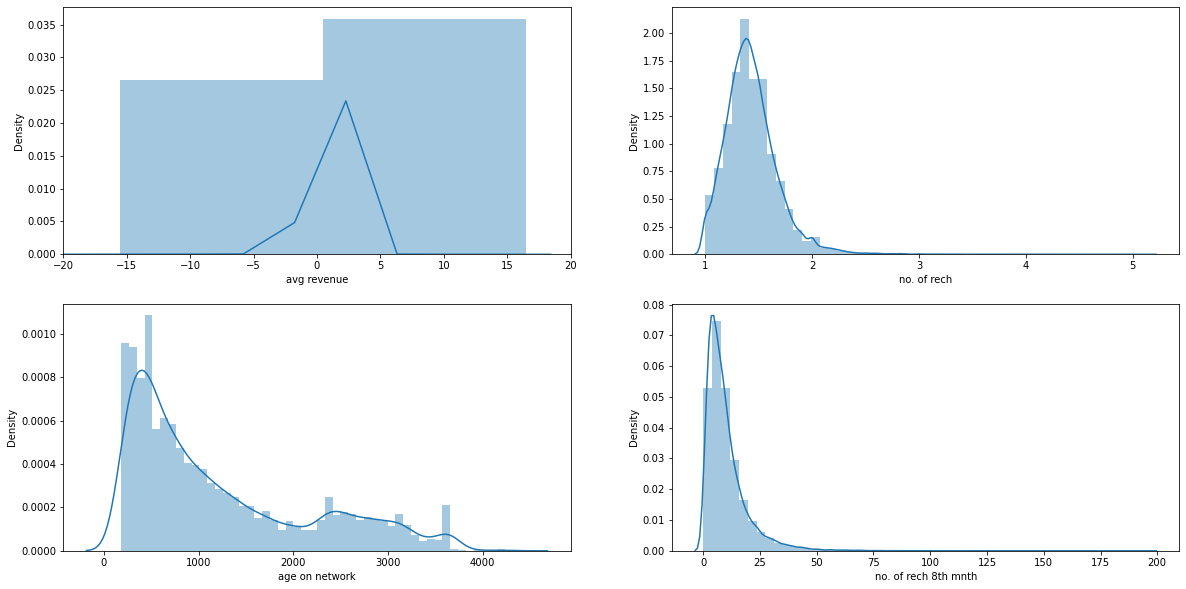

In [53]:
fig,axes = plt.subplots(2,2,figsize = (20,10))
sns.distplot(eda1.arpu, axlabel = "avg revenue", ax = axes[0,0]).set_xlim([-20, 20])
sns.distplot(eda1.rech_num, axlabel = "no. of rech", ax = axes[0,1])
sns.distplot(eda1.aon, axlabel = "age on network", ax = axes[1,0])
sns.distplot(eda1.total_rech_num_8, axlabel = "no. of rech 8th mnth", ax = axes[1,1])
plt.show()

Patterns observed in age on network and number of recharges done, near normal distribution. Around 50% of customers have less than 1000 days (nearly 2.5 years) and 75% customers have less than 1700 days as age on network (nearly 5 years). 

#### Bivariate Analysis :

##### Boxplots for churn and non-churn customers over different predictor variables

In [54]:
box_cols = ['arpu','total_mou','total_roam_mou','total_og_mou','total_ic_mou','isd_og_mou','isd_ic_mou','spl_og_mou',
            'spl_ic_mou', 'ic_others','og_others','total_rech_num_good_phase','total_rech_num_8','rech_num','total_rech_amt',
            'av_rech_amt_data', 'aon','Churn']

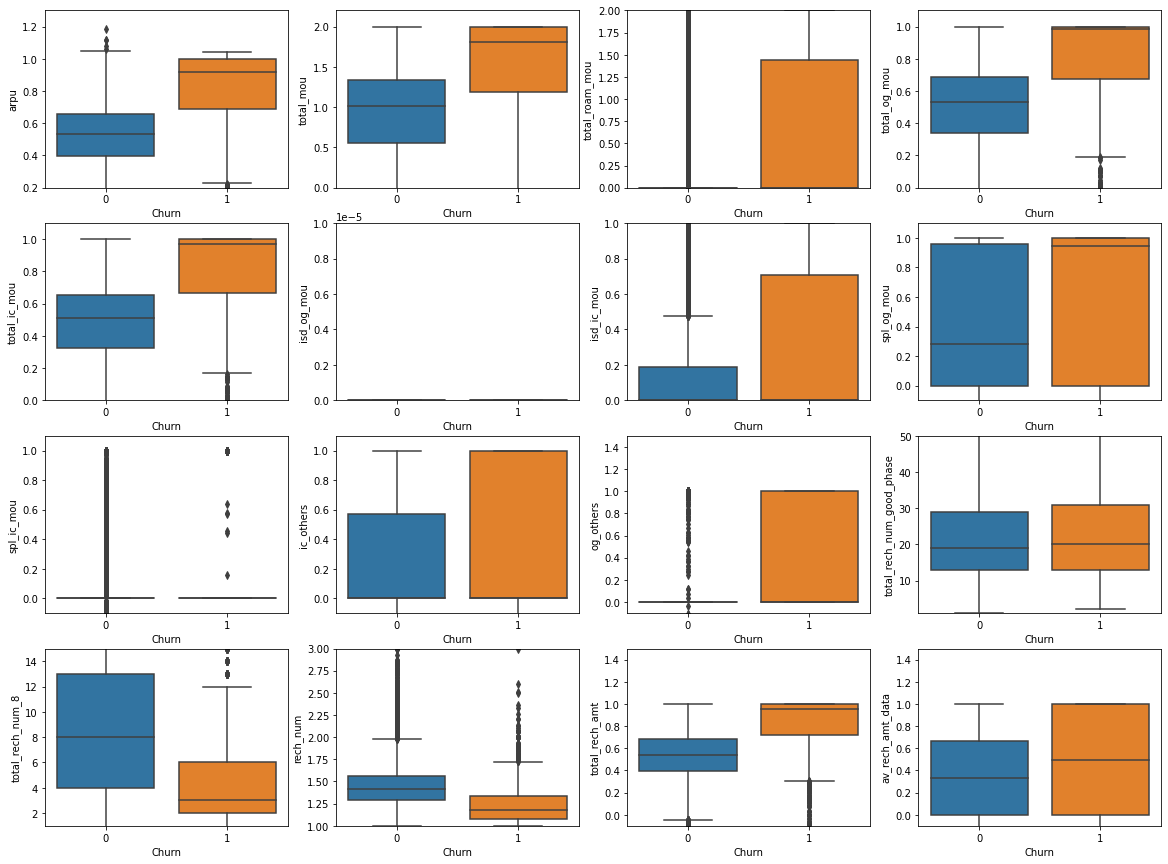

In [55]:
fig,axes = plt.subplots(4,4,figsize = (20,15))
sns.boxplot(data=eda1, x='Churn', y='arpu', ax = axes[0,0]).set_ylim([0.2, 1.3])
sns.boxplot(data=eda1, x='Churn', y='total_mou', ax = axes[0,1]).set_ylim([0, 2.2])
sns.boxplot(data=eda1, x='Churn', y='total_roam_mou', ax = axes[0,2]).set_ylim([0, 2])
sns.boxplot(data=eda1, x='Churn', y='total_og_mou', ax = axes[0,3]).set_ylim([0, 1.1])
sns.boxplot(data=eda1, x='Churn', y='total_ic_mou', ax = axes[1,0]).set_ylim([0, 1.1])
sns.boxplot(data=eda1, x='Churn', y='isd_og_mou', ax = axes[1,1]).set_ylim([0, 0.00001])
sns.boxplot(data=eda1, x='Churn', y='isd_ic_mou', ax = axes[1,2]).set_ylim([0, 1])
sns.boxplot(data=eda1, x='Churn', y='spl_og_mou', ax = axes[1,3]).set_ylim([-0.1, 1.1])
sns.boxplot(data=eda1, x='Churn', y='spl_ic_mou', ax = axes[2,0]).set_ylim([-0.1, 1.1])
sns.boxplot(data=eda1, x='Churn', y='ic_others', ax = axes[2,1]).set_ylim([-0.1, 1.1])
sns.boxplot(data=eda1, x='Churn', y='og_others', ax = axes[2,2]).set_ylim([-0.1, 1.5])
sns.boxplot(data=eda1, x='Churn', y='total_rech_num_good_phase', ax = axes[2,3]).set_ylim([1,50])
sns.boxplot(data=eda1, x='Churn', y='total_rech_num_8', ax = axes[3,0]).set_ylim([1, 15])
sns.boxplot(data=eda1, x='Churn', y='rech_num', ax = axes[3,1]).set_ylim([1,3])
sns.boxplot(data=eda1, x='Churn', y='total_rech_amt', ax = axes[3,2]).set_ylim([-0.1, 1.5])
sns.boxplot(data=eda1, x='Churn', y='av_rech_amt_data', ax = axes[3,3]).set_ylim([-0.1, 1.5])
plt.show()

For majority of the variables, it is clear that the relative change from 6th and 7th month to 8th month for churn customers is greater than that of non-churn customers, except for number of recharges (relative change as well as for 8th month), which indicates lesser number of recharges in the action phase or overall less number of recharges indicate a higher liklihood of churn.

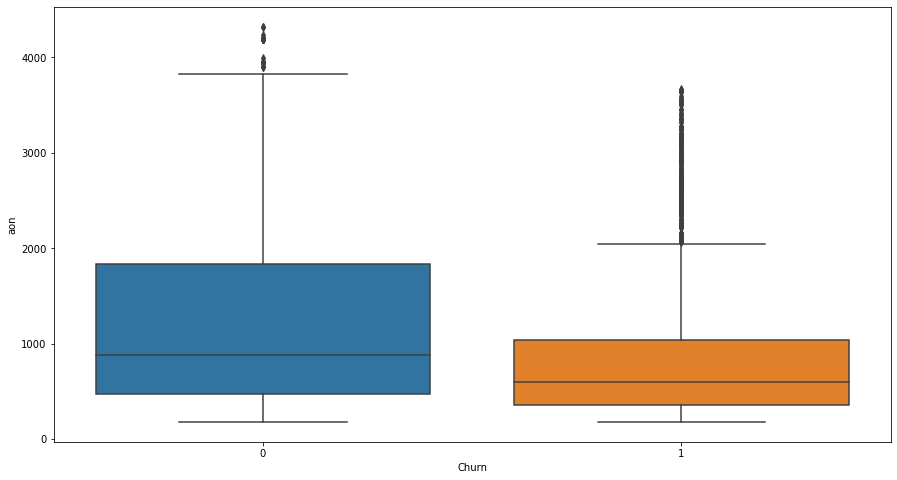

In [56]:
figure(figsize=(15, 8))
sns.boxplot(data=eda1, x='Churn', y='aon')
plt.show()

As observed from box plot of AON against Churn, more than 75% of customers who churn have less than 2.5 yrs as aon, which means 50% customers for the telecom company are at high risk of churning.

In [57]:
eda1.groupby('Churn')[['aon']].quantile([.5, .75, .9])

aon
Churn             
0     0.50   880.0
      0.75  1839.0
      0.90  2830.0
1     0.50   602.0
      0.75  1035.0
      0.90  1990.0

Grouping customers over AON, it is clear that customers who churned spent 30-40% less time with the operator than the customers who didn't churn.

In [58]:
eda1.groupby('Churn')[box_cols].quantile()

,arpu,total_mou,total_roam_mou,total_og_mou,total_ic_mou,isd_og_mou,isd_ic_mou,spl_og_mou,spl_ic_mou,ic_others,og_others,total_rech_num_good_phase,total_rech_num_8,rech_num,total_rech_amt,av_rech_amt_data,aon
Churn,,,,,,,,,,,,,,,,,
0,0.531868,1.012801,0.0,0.528705,0.510812,0.0,0.0,0.278633,0.0,0.0,0.0,19.0,8.0,1.416667,0.539538,0.333333,880.0
1,0.919723,1.809545,0.0,0.985679,0.971061,0.0,0.0,0.947437,0.0,0.0,0.0,20.0,3.0,1.181818,0.956728,0.496162,602.0


Customers who churned have :
- higher average relative change in arpu in 8th month (almost double)
- higher average relative change in mou (almost double for both incoming and outgoing)
- about same number of recharges as the non-churn customers in good phase but half the number of recharges as the churn customers in 8th month (action phase)
- higher relative change in total recharge amount (almost double) and slightly higher for data recharge
- lower average age on network than non-churn customers (by 3/4 or quarter of year)

Correlation matrix and heatmap :

In [59]:
abs(eda1[box_cols].corr()['Churn']).sort_values(ascending = False).head(10)

Churn                        1.000000
total_rech_amt               0.259050
rech_num                     0.236575
total_rech_num_8             0.151888
aon                          0.108271
total_ic_mou                 0.047769
av_rech_amt_data             0.046409
total_rech_num_good_phase    0.029582
og_others                    0.019902
arpu                         0.018781
Name: Churn, dtype: float64

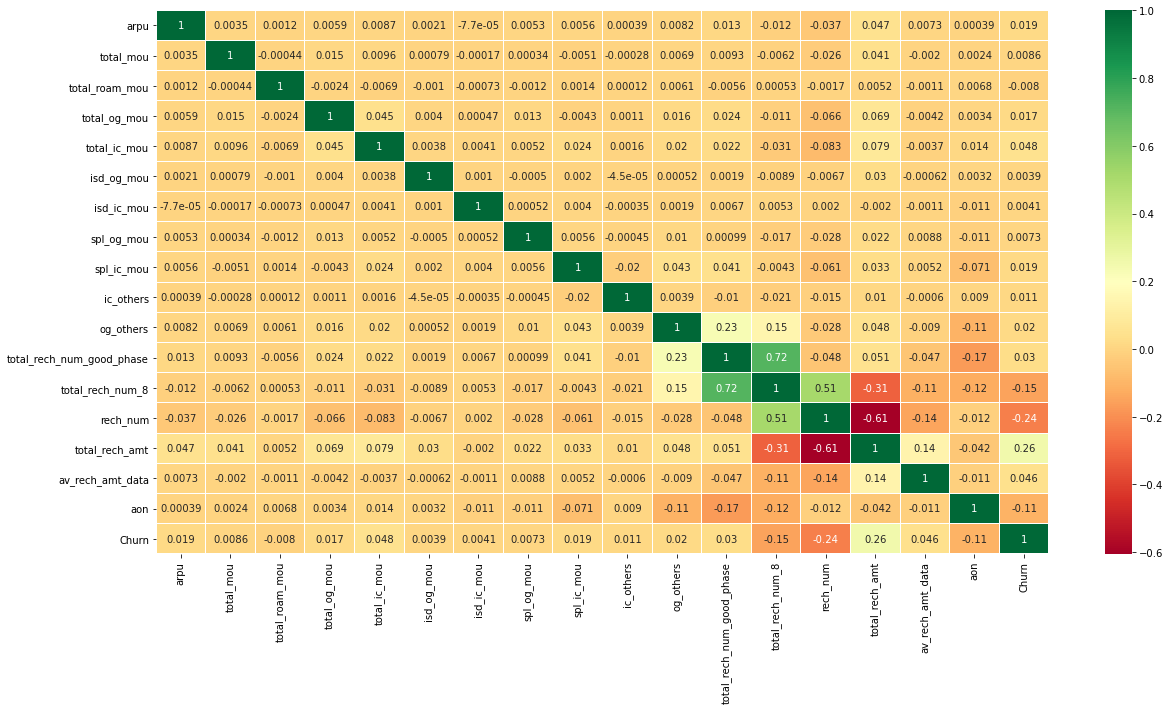

In [60]:
figure(figsize=(20, 10))
sns.heatmap(eda1[box_cols].corr(), linewidth=0.01, annot = True, cmap="RdYlGn")
plt.show()

Except few derived variables there isn't much collinearity in the predictor variables.

##### Observing patterns in churn dataset

In [61]:
#filter churn records from dataset
eda2 = eda1[eda1.Churn == 1]
eda2.head()

,arpu,onnet_mou,offnet_mou,roam_ic_mou,roam_og_mou,loc_og_t2t_mou,loc_og_t2m_mou,loc_og_t2f_mou,loc_og_t2c_mou,loc_og_mou,...,avg_rech_good_phase,total_rech_num_good_phase,total_rech_num_8,rech_num,total_rech_amt,av_rech_amt_data,aon,Churn,total_mou,total_roam_mou
0,0.481314,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.0,0.000000,...,559.0,7,2,1.285714,0.589577,0.5,968,1,0.000000,0.000000
1,-0.311054,0.535283,0.680665,0.363636,-0.047619,0.51335,0.785347,0.54609,0.0,0.732457,...,1185.0,10,7,1.700000,-0.535021,0.0,802,1,1.215948,0.316017
13,0.361505,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.0,0.000000,...,707.0,7,3,1.428571,0.356436,1.0,1158,1,0.000000,0.000000
17,0.997259,1.000000,0.992067,1.000000,0.243363,1.00000,1.000000,1.00000,0.0,1.000000,...,528.0,11,2,1.181818,1.000000,1.0,465,1,1.992067,1.243363
27,1.000000,1.000000,1.000000,0.000000,0.000000,1.00000,1.000000,0.00000,0.0,1.000000,...,644.0,20,5,1.250000,1.000000,1.0,332,1,2.000000,0.000000


In [62]:
eda2.shape

(2433, 40)

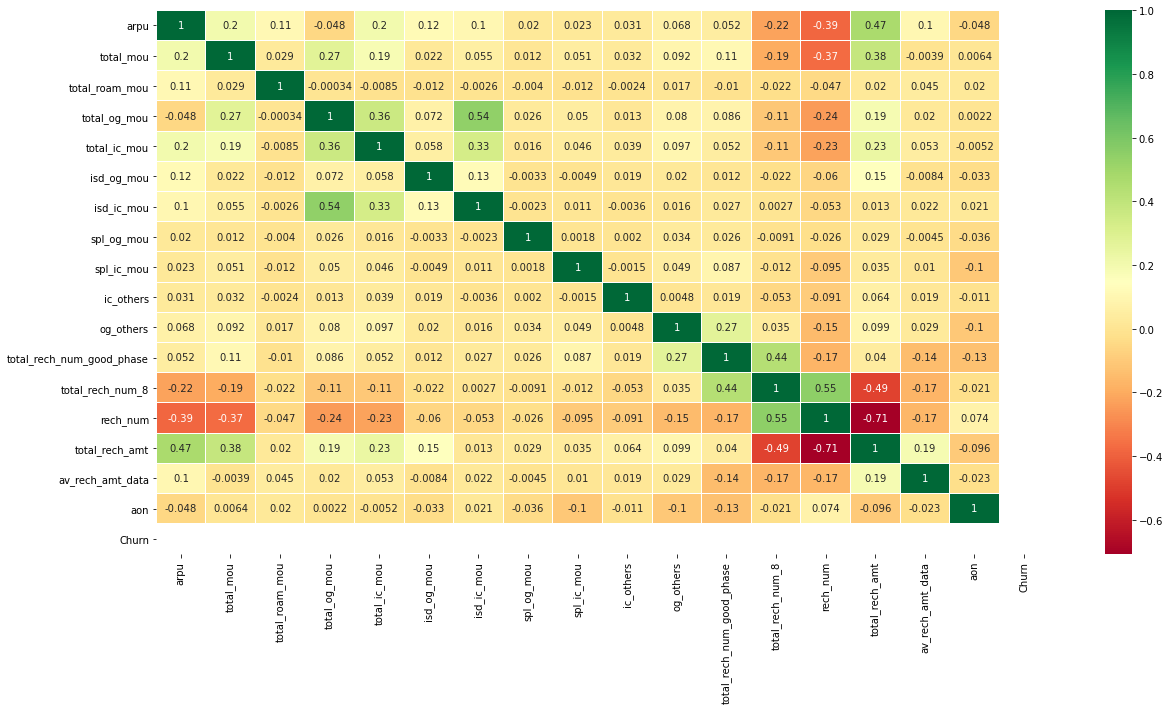

In [63]:
figure(figsize=(20, 10))
sns.heatmap(eda2[box_cols].corr(), linewidth=0.01, annot = True, cmap="RdYlGn")
plt.show()

Since all values in Churn column are the same, there will be no correlation value wrt Churn, but rest of the variables seem to show similar correlation scores as compared to our original dataset (with relative change from good to action phase).

##### Observing patterns in 8th month MOU columns wrt Churn var

In [64]:
mou_cols = ['onnet_mou','offnet_mou','roam_ic_mou','roam_og_mou','loc_og_t2t_mou','loc_og_t2m_mou','loc_og_t2f_mou', 'loc_og_t2c_mou','loc_og_mou','std_og_t2t_mou','std_og_t2m_mou','std_og_t2f_mou','std_og_mou','isd_og_mou', 'spl_og_mou','og_others','total_og_mou','loc_ic_t2t_mou','loc_ic_t2m_mou','loc_ic_t2f_mou','loc_ic_mou', 'std_ic_t2t_mou','std_ic_t2m_mou','std_ic_t2f_mou','std_ic_mou','isd_ic_mou','spl_ic_mou','ic_others','total_ic_mou']

In [65]:
#get list of 8th month MOU columns
mou_cols_8 = []
for col in mou_cols:
    col_8 = col + '_8'
    mou_cols_8.append(col_8)

mou_cols_8.append('Churn')

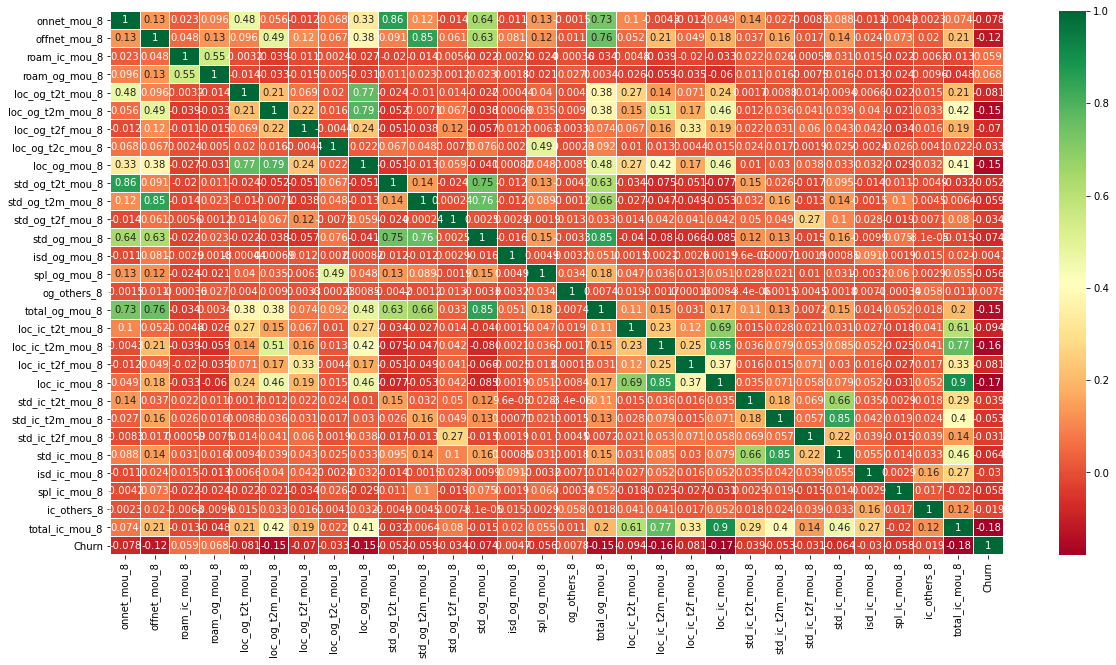

In [66]:
figure(figsize=(20, 10))
sns.heatmap(df[mou_cols_8].corr(), linewidth=0.01, annot = True, cmap="RdYlGn")
plt.show()

In [67]:
abs(df[mou_cols_8].corr()['Churn']).sort_values(ascending = False).head(10)

Churn               1.000000
total_ic_mou_8      0.178178
loc_ic_mou_8        0.172209
loc_ic_t2m_mou_8    0.160949
loc_og_mou_8        0.152392
loc_og_t2m_mou_8    0.152244
total_og_mou_8      0.145208
offnet_mou_8        0.121284
loc_ic_t2t_mou_8    0.094271
loc_ic_t2f_mou_8    0.081385
Name: Churn, dtype: float64

In [68]:
df[mou_cols_8].corr()['Churn'] > 0

onnet_mou_8         False
offnet_mou_8        False
roam_ic_mou_8        True
roam_og_mou_8        True
loc_og_t2t_mou_8    False
loc_og_t2m_mou_8    False
loc_og_t2f_mou_8    False
loc_og_t2c_mou_8    False
loc_og_mou_8        False
std_og_t2t_mou_8    False
std_og_t2m_mou_8    False
std_og_t2f_mou_8    False
std_og_mou_8        False
isd_og_mou_8        False
spl_og_mou_8        False
og_others_8          True
total_og_mou_8      False
loc_ic_t2t_mou_8    False
loc_ic_t2m_mou_8    False
loc_ic_t2f_mou_8    False
loc_ic_mou_8        False
std_ic_t2t_mou_8    False
std_ic_t2m_mou_8    False
std_ic_t2f_mou_8    False
std_ic_mou_8        False
isd_ic_mou_8        False
spl_ic_mou_8        False
ic_others_8         False
total_ic_mou_8      False
Churn                True
Name: Churn, dtype: bool

total incoming and total outgoing MOU, along with local incoming/outgoing and local incoming/outgoing to a different operator have the highest correlation.
- total incoming/outgoing have negative correlation, i.e. the more minutes of use the less likely the customer is to churn
- local incoming/outgoing have negative correlation, i.e. the more minutes of use the less likely the customer is to churn
- roaming incoming/outgoing have positive correlation, i.e. the more minutes of use in roaming the more likely the customer is to churn to a different operator

# Train Test split 

In [69]:
df_init = df.copy()

In [70]:
Y = df.pop('Churn')
X = df

In [71]:
Y

0        1
7        1
8        0
21       0
23       0
        ..
99981    0
99984    0
99986    0
99988    0
99997    0
Name: Churn, Length: 29953, dtype: int64

In [72]:
X

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_data_rech_6,rech_sum_6,total_data_rech_7,rech_sum_7,avg_rech_good_phase
0,7000842753,197.385,214.816,213.803,0.00,0.00,0.00,0.00,0.00,0.00,...,1.0,968,30.40,0.00,101.20,252.0,614.0,252.0,504.0,559.0
7,7000701601,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,...,0.0,802,57.74,19.38,18.74,0.0,1580.0,0.0,790.0,1185.0
8,7001524846,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,...,1.0,315,21.03,910.65,122.16,0.0,437.0,354.0,955.0,696.0
21,7002124215,514.453,597.753,637.760,102.41,132.11,85.14,757.93,896.68,983.39,...,0.0,720,0.00,0.00,0.00,0.0,600.0,0.0,680.0,640.0
23,7000887461,74.350,193.897,366.966,48.96,50.66,33.58,85.41,89.36,205.89,...,1.0,604,40.45,51.86,0.00,0.0,0.0,712.0,1166.0,583.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99981,7000630859,384.316,255.405,393.474,78.68,29.04,103.24,56.13,28.09,61.44,...,1.0,473,1100.43,619.59,668.05,252.0,504.0,252.0,624.0,564.0
99984,7000661676,328.594,202.966,118.707,423.99,181.83,5.71,39.51,39.81,18.26,...,1.0,820,0.00,0.00,0.00,154.0,514.0,484.0,723.0,618.5
99986,7001729035,644.973,455.228,564.334,806.73,549.36,775.41,784.76,617.13,595.44,...,1.0,2696,497.45,598.67,604.08,17.0,584.0,14.0,1144.0,864.0
99988,7002111859,312.558,512.932,402.080,199.89,174.46,2.46,175.88,277.01,248.33,...,1.0,328,104.73,0.00,0.00,0.0,380.0,154.0,708.0,544.0


In [73]:
from sklearn.model_selection import train_test_split

In [74]:
# Splitting the data into train and test
# The sample is stratified wrt 'Y' so that the churn percentage is same in both test and train sets 
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, test_size=0.3, random_state=100,stratify=Y)

In [75]:
X_train

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_data_rech_6,rech_sum_6,total_data_rech_7,rech_sum_7,avg_rech_good_phase
70087,7001991391,521.407,452.594,-0.500,146.33,79.04,5.18,709.74,686.84,0.00,...,0.0,492,0.00,0.00,0.00,0.0,666.0,0.0,500.0,583.0
90560,7001181059,928.353,553.882,789.034,196.91,148.58,235.89,794.93,448.36,827.61,...,1.0,1571,69.27,82.45,0.00,892.0,1873.0,354.0,1075.0,1474.0
58800,7001598590,350.272,390.187,373.309,15.48,77.23,36.78,76.03,97.64,74.06,...,1.0,2875,952.69,934.93,11.29,532.0,925.0,252.0,699.0,812.0
24547,7000276584,537.160,335.809,527.819,101.73,34.09,41.38,245.98,164.73,103.59,...,0.0,839,0.00,0.00,0.00,0.0,576.0,0.0,476.0,526.0
50364,7000083031,2010.382,1555.525,1352.371,387.83,171.08,212.81,2614.99,1783.18,1906.96,...,0.0,187,0.00,0.00,0.00,0.0,2446.0,0.0,2265.0,2355.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69580,7001510994,1444.288,923.123,1064.217,75.49,63.66,90.66,279.01,308.59,302.16,...,1.0,2869,490.71,972.87,617.56,2432.0,4236.0,608.0,1510.0,2873.0
67901,7002038232,350.134,348.427,292.649,27.24,87.09,45.29,248.46,337.96,245.49,...,0.0,2739,0.00,0.00,0.00,154.0,638.0,0.0,510.0,574.0
80741,7001183706,587.112,836.962,683.082,26.03,44.06,23.11,1195.31,1857.76,1397.38,...,0.0,467,0.00,0.00,0.00,0.0,797.0,0.0,935.0,866.0
50324,7000175853,517.629,56.275,14.874,61.21,1.35,15.56,728.71,21.33,5.48,...,0.0,716,0.00,0.00,0.00,368.0,985.0,23.0,43.0,514.0


In [76]:
X_test

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_data_rech_6,rech_sum_6,total_data_rech_7,rech_sum_7,avg_rech_good_phase
38736,7001666981,851.814,949.272,1060.238,214.66,312.89,336.18,522.04,624.23,886.29,...,1.0,3108,141.77,415.78,441.88,154.0,1261.0,154.0,1251.0,1256.0
14328,7000408840,1003.686,1059.923,946.014,553.23,354.99,494.83,1069.24,953.16,1125.54,...,0.0,735,0.00,0.00,0.00,25.0,1212.0,25.0,1375.0,1293.5
54761,7001657252,539.646,717.827,127.752,23.71,32.24,1.98,198.51,340.33,41.64,...,0.0,438,0.00,0.00,0.00,0.0,650.0,0.0,800.0,725.0
43872,7000165729,315.278,447.164,363.532,58.36,43.51,53.03,132.03,67.28,77.73,...,1.0,961,47.53,152.05,229.24,484.0,830.0,2352.0,2861.0,1845.5
22105,7002150725,456.397,864.573,895.869,386.09,218.88,158.69,437.23,461.03,241.56,...,1.0,489,1165.19,447.61,0.00,0.0,540.0,154.0,1174.0,857.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6813,7001875960,757.388,647.047,957.434,570.41,324.88,1129.98,672.16,337.13,357.51,...,0.0,1378,0.00,0.00,0.00,25.0,863.0,0.0,722.0,792.5
15915,7001656513,158.607,156.756,141.592,4.31,9.54,0.31,24.49,27.68,9.29,...,1.0,928,0.00,0.00,0.00,1472.0,1639.0,738.0,896.0,1267.5
8789,7002315586,201.418,45.110,166.720,76.21,4.03,60.53,38.98,1.83,29.91,...,1.0,869,0.00,0.00,0.00,636.0,867.0,68.0,122.0,494.5
23384,7000156891,757.112,876.755,259.007,86.43,69.61,55.08,1283.38,1114.99,19.49,...,0.0,857,0.00,0.00,0.00,92.0,1039.0,92.0,1202.0,1120.5


In [77]:
# chekcing y_train_1 and y_test_1 have similar levels of churn values 
y_train.mean()

0.08122287404015835

In [78]:
y_test.mean()

0.08123748052526152

# Standardisation 

In [79]:
from sklearn.preprocessing import StandardScaler

In [80]:
scaler = StandardScaler()

In [81]:
qwer = list(X_train.columns)

In [82]:
qwer

['mobile_number',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_

In [83]:
qwer.remove('mobile_number')

In [84]:
# Standardizing
X_train[qwer] = scaler.fit_transform(X_train[qwer])
X_train

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_data_rech_6,rech_sum_6,total_data_rech_7,rech_sum_7,avg_rech_good_phase
70087,7001991391,-0.082112,-0.244799,-1.067074,-0.246508,-0.391759,-0.497451,0.694603,0.623999,-0.706561,...,-0.961948,-0.748512,-0.407037,-0.408828,-0.392176,-0.347642,-0.311607,-0.370320,-0.436792,-0.439512
90560,7001181059,0.846654,-0.016165,0.581212,-0.137171,-0.246802,0.001323,0.870874,0.143034,1.039107,...,1.039557,0.381438,-0.240737,-0.221611,-0.392176,0.336864,0.527603,-0.123034,-0.072915,0.248485
58800,7001598590,-0.472691,-0.385669,-0.286684,-0.529361,-0.395532,-0.429134,-0.616639,-0.564296,-0.550347,...,1.039557,1.747013,1.880134,1.714094,-0.364263,0.060606,-0.131528,-0.194286,-0.310859,-0.262687
24547,7000276584,-0.046159,-0.508414,0.035882,-0.342918,-0.485458,-0.419189,-0.264987,-0.428989,-0.488059,...,-0.961948,-0.385127,-0.407037,-0.408828,-0.392176,-0.347642,-0.374183,-0.370320,-0.451980,-0.483526
50364,7000083031,3.316151,2.244814,1.757274,0.275533,-0.199901,-0.048573,4.636854,2.835090,3.315765,...,-0.961948,-1.067914,-0.407037,-0.408828,-0.392176,-0.347642,0.926003,-0.370320,0.680151,0.929146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69580,7001510994,2.024164,0.817312,1.155704,-0.399640,-0.423819,-0.312651,-0.196643,-0.138853,-0.069218,...,1.039557,1.740730,0.771035,1.800244,1.134649,1.518634,2.170565,0.054397,0.202365,1.328741
67901,7002038232,-0.473006,-0.479932,-0.455075,-0.503940,-0.374979,-0.410736,-0.259856,-0.079620,-0.188752,...,-0.961948,1.604591,-0.407037,-0.408828,-0.392176,-0.229465,-0.331075,-0.370320,-0.430464,-0.446462
80741,7001183706,0.067845,0.622823,0.360020,-0.506555,-0.464675,-0.458688,1.699321,2.985502,2.240915,...,-0.961948,-0.774693,-0.407037,-0.408828,-0.392176,-0.347642,-0.220525,-0.370320,-0.161511,-0.220990
50324,7000175853,-0.090735,-1.139398,-1.034978,-0.430508,-0.553704,-0.475010,0.733855,-0.718197,-0.695002,...,-0.961948,-0.513935,-0.407037,-0.408828,-0.392176,-0.065245,-0.089811,-0.354253,-0.725995,-0.492792


In [85]:
# Standardizing
X_test[qwer] = scaler.transform(X_test[qwer])
X_test

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_data_rech_6,rech_sum_6,total_data_rech_7,rech_sum_7,avg_rech_good_phase
38736,7001666981,0.671970,0.876337,1.147397,-0.098802,0.095703,0.218141,0.306223,0.497727,1.162879,...,1.039557,1.991016,-0.066682,0.535273,0.700307,-0.229465,0.102088,-0.262744,0.038462,0.080153
14328,7000408840,1.018585,1.126106,0.908935,0.633071,0.183461,0.561128,1.438463,1.161111,1.667526,...,-0.961948,-0.494038,-0.407037,-0.408828,-0.392176,-0.328457,0.068019,-0.352856,0.116933,0.109109
54761,7001657252,-0.040486,0.353903,-0.799326,-0.511570,-0.489314,-0.504369,-0.363210,-0.074840,-0.618730,...,-0.961948,-0.805062,-0.407037,-0.408828,-0.392176,-0.347642,-0.322732,-0.370320,-0.246943,-0.329865
43872,7000165729,-0.552557,-0.257056,-0.307095,-0.436669,-0.465821,-0.394003,-0.500767,-0.625526,-0.542606,...,1.039557,-0.257366,-0.292929,-0.063572,0.174586,0.023771,-0.197580,1.272663,1.057317,0.535343
22105,7002150725,-0.230483,0.685149,0.804249,0.271772,-0.100261,-0.165576,0.130738,0.168587,-0.197041,...,1.039557,-0.751654,2.390293,0.607549,-0.392176,-0.347642,-0.399214,-0.262744,-0.010265,-0.227940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6813,7001875960,0.456463,0.194134,0.932776,0.670209,0.120697,1.934265,0.616844,-0.081294,0.047531,...,-0.961948,0.179325,-0.407037,-0.408828,-0.392176,-0.328457,-0.174636,-0.370320,-0.296304,-0.277744
15915,7001656513,-0.910125,-0.912585,-0.770432,-0.553507,-0.536632,-0.507979,-0.723283,-0.705391,-0.686965,...,1.039557,-0.291924,-0.407037,-0.408828,-0.392176,0.781946,0.364906,0.145208,-0.186192,0.089033
8789,7002315586,-0.812418,-1.164601,-0.717974,-0.398083,-0.548118,-0.377789,-0.693301,-0.757525,-0.643472,...,1.039557,-0.353710,-0.407037,-0.408828,-0.392176,0.140414,-0.171855,-0.322819,-0.676001,-0.507849
23384,7000156891,0.455833,0.712647,-0.525309,-0.375991,-0.411416,-0.389571,1.881551,1.487489,-0.665450,...,-0.961948,-0.366277,-0.407037,-0.408828,-0.392176,-0.277043,-0.052266,-0.306053,0.007454,-0.024475


## Function for Test Evaluation Dataset 

In [86]:
model = list()
resample = list()
PCA_YN = list()
precision = list()
recall = list()
F1score = list()
AUCROC = list()
accuracy = list()

In [87]:
# Function  for evaluation and inputting into data frame 

def test_eval(clf_model, X_test, y_test, algo=None, sampling='No',pca_YN = 'PCA'):
    # Test set prediction
    y_prob=clf_model.predict_proba(X_test)
    y_pred=clf_model.predict(X_test)

    print('Confusion Matrix')
    print('='*60)
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_test, y_prob[:,1]))
    
    
    accuracy.append(metrics.accuracy_score(y_test,y_pred))
    model.append(algo)
    PCA_YN.append(pca_YN)
    precision.append(precision_score(y_test,y_pred))
    recall.append(recall_score(y_test,y_pred))
    F1score.append(f1_score(y_test,y_pred))
    AUCROC.append(roc_auc_score(y_test, y_prob[:,1]))
    resample.append(sampling)

# <font color='red'>Telecom Churn case study - basic

In [88]:
# Popping mobile_number to add later 
z1 = X_train.pop('mobile_number')

In [89]:
# Popping mobile_number to add later 
z2 = X_test.pop('mobile_number')

In [90]:
X_train_1 = X_train.copy()

In [91]:
X_test_1 = X_test.copy()

In [92]:
y_train_1 = y_train.copy()

In [93]:
y_test_1 = y_test.copy()

## Doing Rfecv to select the optimum number of parameters 

RFECV uses recursive feature elimination with cross validation for the selection of optimal number of features

If we are using RFE, we would have to manually input the number of features and check which is the best optimal limit 

Since RFECV takes a long time to process, the optimal parameter values are taken and given to a list 

In [94]:
# # Create the RFE object and compute a cross-validated score.
# # The "RMSE" is selected as it gives scores very close to the target value and gives better R2 value 

# rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring=metrics.make_scorer(metrics.f1_score))
# rfecv.fit(X_train_1,y_train_1 )

# rfeCV takes a long time to load. 
# To Reduce that process, the optimal value obtained using RFECV is taken and given to normal RFE

# print("Optimal number of features: %d" % rfecv.n_features_)


# # Plot number of features VS. cross-validation scores
# plt.figure(figsize=(10,6))
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
# plt.show()

Optimal number of features: 138

Selected features: ['arpu_6', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_8', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_7', 'total_ic_mou_8', 'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8', 'isd_ic_mou_7', 'isd_ic_mou_8', 'ic_others_6', 'ic_others_7', 'ic_others_8', 'total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8', 'total_rech_data_6', 'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'count_rech_2g_6', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'night_pck_user_6', 'night_pck_user_7', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'fb_user_7', 'fb_user_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'total_data_rech_6', 'total_data_rech_7']

In [95]:
l1 = ['arpu_6', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 
      'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 
      'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 
      'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_7', 'loc_og_mou_8', 
      'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 
      'std_og_t2f_mou_6', 'std_og_t2f_mou_8', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 
      'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7', 'total_og_mou_7', 'total_og_mou_8', 
      'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 
      'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 
      'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8', 
      'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 
      'total_ic_mou_7', 'total_ic_mou_8', 'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8', 'isd_ic_mou_7', 'isd_ic_mou_8', 
      'ic_others_6', 'ic_others_7', 'ic_others_8', 'total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 
      'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 
      'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8', 'total_rech_data_6', 'total_rech_data_8', 
      'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'count_rech_2g_6', 'count_rech_2g_8', 'count_rech_3g_6', 
      'count_rech_3g_7', 'count_rech_3g_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'vol_2g_mb_6', 
      'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_2g_6', 
      'arpu_2g_7', 'arpu_2g_8', 'night_pck_user_6', 'night_pck_user_7', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 
      'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 
      'sachet_3g_7', 'sachet_3g_8', 'fb_user_7', 'fb_user_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 
      'total_data_rech_6', 'total_data_rech_7']

## Logistic Regression 

In [96]:
lr = LogisticRegression()

In [97]:
X_train_1

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_data_rech_6,rech_sum_6,total_data_rech_7,rech_sum_7,avg_rech_good_phase
70087,-0.082112,-0.244799,-1.067074,-0.246508,-0.391759,-0.497451,0.694603,0.623999,-0.706561,-0.213738,...,-0.961948,-0.748512,-0.407037,-0.408828,-0.392176,-0.347642,-0.311607,-0.370320,-0.436792,-0.439512
90560,0.846654,-0.016165,0.581212,-0.137171,-0.246802,0.001323,0.870874,0.143034,1.039107,-0.213738,...,1.039557,0.381438,-0.240737,-0.221611,-0.392176,0.336864,0.527603,-0.123034,-0.072915,0.248485
58800,-0.472691,-0.385669,-0.286684,-0.529361,-0.395532,-0.429134,-0.616639,-0.564296,-0.550347,-0.213738,...,1.039557,1.747013,1.880134,1.714094,-0.364263,0.060606,-0.131528,-0.194286,-0.310859,-0.262687
24547,-0.046159,-0.508414,0.035882,-0.342918,-0.485458,-0.419189,-0.264987,-0.428989,-0.488059,-0.213738,...,-0.961948,-0.385127,-0.407037,-0.408828,-0.392176,-0.347642,-0.374183,-0.370320,-0.451980,-0.483526
50364,3.316151,2.244814,1.757274,0.275533,-0.199901,-0.048573,4.636854,2.835090,3.315765,3.269565,...,-0.961948,-1.067914,-0.407037,-0.408828,-0.392176,-0.347642,0.926003,-0.370320,0.680151,0.929146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69580,2.024164,0.817312,1.155704,-0.399640,-0.423819,-0.312651,-0.196643,-0.138853,-0.069218,-0.213738,...,1.039557,1.740730,0.771035,1.800244,1.134649,1.518634,2.170565,0.054397,0.202365,1.328741
67901,-0.473006,-0.479932,-0.455075,-0.503940,-0.374979,-0.410736,-0.259856,-0.079620,-0.188752,-0.213738,...,-0.961948,1.604591,-0.407037,-0.408828,-0.392176,-0.229465,-0.331075,-0.370320,-0.430464,-0.446462
80741,0.067845,0.622823,0.360020,-0.506555,-0.464675,-0.458688,1.699321,2.985502,2.240915,-0.213738,...,-0.961948,-0.774693,-0.407037,-0.408828,-0.392176,-0.347642,-0.220525,-0.370320,-0.161511,-0.220990
50324,-0.090735,-1.139398,-1.034978,-0.430508,-0.553704,-0.475010,0.733855,-0.718197,-0.695002,-0.143861,...,-0.961948,-0.513935,-0.407037,-0.408828,-0.392176,-0.065245,-0.089811,-0.354253,-0.725995,-0.492792


In [98]:
X_train_1_l1 = X_train_1[l1]
X_test_1_l1 = X_test_1[l1]

In [99]:
lr.fit(X_train_1_l1,y_train_1)

LogisticRegression()

In [100]:
y_pred_lr = lr.predict(X_train_1_l1)

In [101]:
print(classification_report(y_train_1,y_pred_lr))
confusion_matrix(y_train_1,y_pred_lr)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     19264
           1       0.69      0.29      0.40      1703

    accuracy                           0.93     20967
   macro avg       0.82      0.64      0.68     20967
weighted avg       0.92      0.93      0.92     20967



array([[19050,   214],
       [ 1217,   486]], dtype=int64)

In [102]:
test_eval(lr, X_test_1_l1, y_test_1, 'LogisticRegression',pca_YN = 'RFECV-Recall')

Confusion Matrix
[[8146  110]
 [ 523  207]] 

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      8256
           1       0.65      0.28      0.40       730

    accuracy                           0.93      8986
   macro avg       0.80      0.64      0.68      8986
weighted avg       0.92      0.93      0.92      8986
 

AUC-ROC
0.8971487734947435


## Random forest

In [103]:
rf = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=7)

In [104]:
rf.fit(X_train_1, y_train_1)

RandomForestClassifier(max_depth=7, n_estimators=10, random_state=42)

In [105]:
y_train_1_pred_rf = rf.predict(X_train_1)

In [106]:
print(classification_report(y_train_1, y_train_1_pred_rf))
confusion_matrix(y_train_1, y_train_1_pred_rf)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     19264
           1       0.77      0.50      0.60      1703

    accuracy                           0.95     20967
   macro avg       0.86      0.74      0.79     20967
weighted avg       0.94      0.95      0.94     20967



array([[19005,   259],
       [  854,   849]], dtype=int64)

In [107]:
y_test_1_pred_rf = rf.predict(X_test_1)

In [108]:
test_eval(rf, X_test_1, y_test_1, 'Random Forest',pca_YN = 'No')

Confusion Matrix
[[8120  136]
 [ 353  377]] 

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      8256
           1       0.73      0.52      0.61       730

    accuracy                           0.95      8986
   macro avg       0.85      0.75      0.79      8986
weighted avg       0.94      0.95      0.94      8986
 

AUC-ROC
0.9162714372942552


In [109]:
rf1 = rf.feature_importances_

## RandomForestCV

In [110]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [111]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [ 2, 5],
    'min_samples_leaf': [2,5],
    'max_features': [5,8],
    'n_estimators': [5,10]
}

In [112]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=classifier_rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = metrics.make_scorer(metrics.recall_score))

In [113]:
%%time
grid_search.fit(X_train_1, y_train_1)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
Wall time: 6.84 s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 5], 'max_features': [5, 8],
                         'min_samples_leaf': [2, 5], 'n_estimators': [5, 10]},
             scoring=make_scorer(recall_score), verbose=1)

In [114]:
rfcv_best = grid_search.best_estimator_

In [115]:
rfcv_best

RandomForestClassifier(max_depth=5, max_features=8, min_samples_leaf=5,
                       n_estimators=10, n_jobs=-1, random_state=42)

In [116]:
y_train_1_pred_rfcv = rfcv_best.predict(X_train_1)

In [117]:
print(classification_report(y_train_1, y_train_1_pred_rfcv))
confusion_matrix(y_train_1, y_train_1_pred_rfcv)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     19264
           1       0.76      0.45      0.57      1703

    accuracy                           0.94     20967
   macro avg       0.86      0.72      0.77     20967
weighted avg       0.94      0.94      0.94     20967



array([[19020,   244],
       [  933,   770]], dtype=int64)

In [118]:
y_test_1_pred_rfcv = rfcv_best.predict(X_test_1)

In [119]:
test_eval(rfcv_best, X_test_1, y_test_1, 'Random Forest CV',pca_YN = 'No')

Confusion Matrix
[[8137  119]
 [ 375  355]] 

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      8256
           1       0.75      0.49      0.59       730

    accuracy                           0.95      8986
   macro avg       0.85      0.74      0.78      8986
weighted avg       0.94      0.95      0.94      8986
 

AUC-ROC
0.9105508156790909


In [120]:
rfcv1 = rfcv_best.feature_importances_

## XGB

In [121]:
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic',n_estimators = 100, gamma = 0.1, learning_rate = 0.05, 
                            max_depth = 5, min_child_weight= 7, subsample = 0.8 )
xgb_cfl.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': 0.1,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.05,
 'max_delta_step': None,
 'max_depth': 5,
 'min_child_weight': 7,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [122]:
# Fit the model to our train and target
xgb_cfl.fit(X_train_1, y_train_1)  # default 

[21:09:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [123]:
# Get our predictions
y_train_1_pred_xgb = xgb_cfl.predict(X_train_1)

In [124]:
print(classification_report(y_train_1, y_train_1_pred_xgb))
confusion_matrix(y_train_1, y_train_1_pred_xgb)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     19264
           1       0.78      0.56      0.65      1703

    accuracy                           0.95     20967
   macro avg       0.87      0.77      0.81     20967
weighted avg       0.95      0.95      0.95     20967



array([[18997,   267],
       [  753,   950]], dtype=int64)

In [125]:
# Get our predictions
y_test_1_pred_xgb = xgb_cfl.predict(X_test_1)

In [126]:
test_eval(xgb_cfl, X_test_1, y_test_1, 'XGB',pca_YN = 'No')

Confusion Matrix
[[8094  162]
 [ 313  417]] 

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      8256
           1       0.72      0.57      0.64       730

    accuracy                           0.95      8986
   macro avg       0.84      0.78      0.80      8986
weighted avg       0.94      0.95      0.94      8986
 

AUC-ROC
0.9374430882977594


In [127]:
xgb1 = xgb_cfl.feature_importances_

## XGB Gridsearch

In [128]:
# params = {'n_estimators' : [100, 200],
#         'learning_rate' : [0.1, 0.05],  # eta
#         'min_child_weight': [5,7],
#         'gamma': [0.1, 0.5],
#         'subsample': [0.6, 0.8],
#         'max_depth': [2,3]
#         }

# folds = 4

# param_comb = 600

# xgb_search = GridSearchCV(xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic'), param_grid=params, 
#                           cv=3, n_jobs=-1, verbose=1, scoring = metrics.make_scorer(metrics.recall_score))




In [129]:
# %%time
# xgb_search.fit(X_train_1, y_train_1)

In [130]:
# print('\n Best estimator:')
# print(xgb_search.best_estimator_)
# print('\n Best accuracy for %d-fold search with %d parameter combinations:' % (folds, param_comb))
# print(xgb_search.best_score_ )
# print('\n Best hyperparameters:')
# print(xgb_search.best_params_)

Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

 Best accuracy for 4-fold search with 600 parameter combinations:
0.5149808314910037

Best hyperparameters:

{'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 200, 'subsample': 0.8}

In [131]:
xgbcv_best= xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic',n_estimators = 200, gamma = 0.5, learning_rate = 0.1, 
                            max_depth = 3, min_child_weight= 7, subsample = 0.8 )
xgbcv_best.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': 0.5,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_delta_step': None,
 'max_depth': 3,
 'min_child_weight': 7,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 200,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [132]:
# Fit the model to our train and target
xgbcv_best.fit(X_train_1, y_train_1)  # default 

[21:09:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [133]:
y_train_1_pred_xgbcv = xgbcv_best.predict(X_train_1)

In [134]:
print(classification_report(y_train_1, y_train_1_pred_xgbcv))
confusion_matrix(y_train_1, y_train_1_pred_xgbcv)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     19264
           1       0.78      0.58      0.67      1703

    accuracy                           0.95     20967
   macro avg       0.87      0.78      0.82     20967
weighted avg       0.95      0.95      0.95     20967



array([[18982,   282],
       [  712,   991]], dtype=int64)

In [135]:
y_test_1_pred_xgbcv = xgbcv_best.predict(X_test_1)

In [136]:
test_eval(xgbcv_best, X_test_1, y_test_1, 'XGB CV',pca_YN = 'No')

Confusion Matrix
[[8077  179]
 [ 318  412]] 

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      8256
           1       0.70      0.56      0.62       730

    accuracy                           0.94      8986
   macro avg       0.83      0.77      0.80      8986
weighted avg       0.94      0.94      0.94      8986
 

AUC-ROC
0.9371130667940958


In [137]:
xgbcv1 = xgbcv_best.feature_importances_

# <font color='red'>Telecom Churn case study - Basic with SMOTE

In [138]:
X_train_2 = X_train.copy()

In [139]:
X_test_2 = X_test.copy()

In [140]:
y_train_2 = y_train.copy()

In [141]:
y_test_2 = y_test.copy()

## Handling class imbalance using SMOTE 

In [142]:
# from imblearn.over_sampling import SMOTE
# from collections import Counter

counter = Counter(y_train_2)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()

X_train_2, y_train_2 = smt.fit_resample(X_train_2, y_train_2)

counter = Counter(y_train_2)
print('After',counter)

Before Counter({0: 19264, 1: 1703})
After Counter({1: 19264, 0: 19264})


## Doing Rfecv to select the optimum number of parameters 

RFECV uses recursive feature elimination with cross validation for the selection of optimal number of features

If we are using RFE, we would have to manually input the number of features and check which is the best optimal limit 

Since RFECV takes a long time to process, the optimal parameter values are taken and given to a list 

In [143]:
# # Create the RFE object and compute a cross-validated score.
# # The "RMSE" is selected as it gives scores very close to the target value and gives better R2 value 

# rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring=metrics.make_scorer(metrics.f1_score))
# rfecv.fit(X_train_1,y_train_1 )

# rfeCV takes a long time to load. 
# To Reduce that process, the optimal value obtained using RFECV is taken and given to normal RFE

# print("Optimal number of features: %d" % rfecv.n_features_)
# print('Selected features: %s' % list(X_train_1.columns[rfecv.support_]))
# l1 = list(X_train_1.columns[rfecv.support_])

# # Plot number of features VS. cross-validation scores
# plt.figure(figsize=(10,6))
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
# plt.show()

Optimal number of features: 129
    
Selected features: ['arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 
                    'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7',
                    'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 
                    'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 
                    'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 
                    'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 
                    'std_og_t2f_mou_6', 'std_og_t2f_mou_8', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7',
                    'isd_og_mou_8', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7', 'total_og_mou_7', 
                    'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 
                    'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 
                    'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 
                    'std_ic_t2m_mou_8', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8', 'std_ic_mou_8', 'total_ic_mou_6', 
                    'total_ic_mou_7', 'total_ic_mou_8', 'spl_ic_mou_7', 'spl_ic_mou_8', 'isd_ic_mou_6', 'isd_ic_mou_7', 
                    'isd_ic_mou_8', 'ic_others_6', 'ic_others_7', 'ic_others_8', 'total_rech_num_6', 'total_rech_num_7',
                    'total_rech_num_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'max_rech_amt_6', 
                    'max_rech_amt_7', 'max_rech_amt_8', 'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8', 
                    'total_rech_data_6', 'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 
                    'count_rech_2g_6', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_8', 'av_rech_amt_data_6', 
                    'av_rech_amt_data_7', 'av_rech_amt_data_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_7', 
                    'vol_3g_mb_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'night_pck_user_6', 
                    'night_pck_user_7', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'sachet_2g_6', 'sachet_2g_7', 
                    'sachet_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'fb_user_7', 'fb_user_8',
                    'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'total_data_rech_6', 'total_data_rech_7']

In [144]:
l1 = ['arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 
                    'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7',
                    'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 
                    'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 
                    'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 
                    'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 
                    'std_og_t2f_mou_6', 'std_og_t2f_mou_8', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7',
                    'isd_og_mou_8', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7', 'total_og_mou_7', 
                    'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 
                    'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 
                    'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 
                    'std_ic_t2m_mou_8', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8', 'std_ic_mou_8', 'total_ic_mou_6', 
                    'total_ic_mou_7', 'total_ic_mou_8', 'spl_ic_mou_7', 'spl_ic_mou_8', 'isd_ic_mou_6', 'isd_ic_mou_7', 
                    'isd_ic_mou_8', 'ic_others_6', 'ic_others_7', 'ic_others_8', 'total_rech_num_6', 'total_rech_num_7',
                    'total_rech_num_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'max_rech_amt_6', 
                    'max_rech_amt_7', 'max_rech_amt_8', 'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8', 
                    'total_rech_data_6', 'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 
                    'count_rech_2g_6', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_8', 'av_rech_amt_data_6', 
                    'av_rech_amt_data_7', 'av_rech_amt_data_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_7', 
                    'vol_3g_mb_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'night_pck_user_6', 
                    'night_pck_user_7', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'sachet_2g_6', 'sachet_2g_7', 
                    'sachet_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'fb_user_7', 'fb_user_8',
                    'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'total_data_rech_6', 'total_data_rech_7']

## Logistic Regression 

In [145]:
lr = LogisticRegression()

In [146]:
X_train_2

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_data_rech_6,rech_sum_6,total_data_rech_7,rech_sum_7,avg_rech_good_phase
0,-0.082112,-0.244799,-1.067074,-0.246508,-0.391759,-0.497451,0.694603,0.623999,-0.706561,-0.213738,...,-0.961948,-0.748512,-0.407037,-0.408828,-0.392176,-0.347642,-0.311607,-0.370320,-0.436792,-0.439512
1,0.846654,-0.016165,0.581212,-0.137171,-0.246802,0.001323,0.870874,0.143034,1.039107,-0.213738,...,1.039557,0.381438,-0.240737,-0.221611,-0.392176,0.336864,0.527603,-0.123034,-0.072915,0.248485
2,-0.472691,-0.385669,-0.286684,-0.529361,-0.395532,-0.429134,-0.616639,-0.564296,-0.550347,-0.213738,...,1.039557,1.747013,1.880134,1.714094,-0.364263,0.060606,-0.131528,-0.194286,-0.310859,-0.262687
3,-0.046159,-0.508414,0.035882,-0.342918,-0.485458,-0.419189,-0.264987,-0.428989,-0.488059,-0.213738,...,-0.961948,-0.385127,-0.407037,-0.408828,-0.392176,-0.347642,-0.374183,-0.370320,-0.451980,-0.483526
4,3.316151,2.244814,1.757274,0.275533,-0.199901,-0.048573,4.636854,2.835090,3.315765,3.269565,...,-0.961948,-1.067914,-0.407037,-0.408828,-0.392176,-0.347642,0.926003,-0.370320,0.680151,0.929146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38523,0.315581,-0.114805,-1.066030,0.287134,-0.013894,-0.508649,0.895489,0.155613,-0.706561,-0.213738,...,-0.961948,-0.425294,-0.407037,-0.408828,-0.392176,-0.347642,-0.217614,-0.370320,-0.392673,-0.360403
38524,-0.538610,-0.885001,-1.038830,-0.459993,-0.556518,-0.506887,-0.631267,-0.721565,-0.689263,0.045836,...,-0.732420,-0.869888,-0.407037,-0.081534,0.196969,0.098433,-0.115208,0.451675,0.120301,0.009421
38525,-0.395297,-0.155663,-0.897808,-0.160321,-0.103177,-0.415375,0.015814,0.454296,-0.470371,-0.146301,...,-0.961948,-0.847416,-0.407037,-0.408828,-0.392176,-0.347642,-0.460440,-0.358339,-0.392251,-0.494983
38526,0.844504,-1.232844,-1.022788,0.018810,-0.556433,-0.485725,0.365030,-0.758792,-0.646945,0.677631,...,-0.961948,-0.748169,-0.407037,-0.408828,-0.392176,-0.347642,0.145138,-0.370320,-0.753206,-0.378929


In [147]:
X_train_2_l1 = X_train_2[l1]
X_test_2_l1 = X_test_2[l1]

In [148]:
lr.fit(X_train_2_l1,y_train_2)

LogisticRegression()

In [149]:
y_pred_lr = lr.predict(X_train_2_l1)

In [150]:
print(classification_report(y_train_2,y_pred_lr))
confusion_matrix(y_train_2,y_pred_lr)

              precision    recall  f1-score   support

           0       0.86      0.83      0.84     19264
           1       0.83      0.86      0.85     19264

    accuracy                           0.85     38528
   macro avg       0.85      0.85      0.85     38528
weighted avg       0.85      0.85      0.85     38528



array([[15929,  3335],
       [ 2605, 16659]], dtype=int64)

In [151]:
test_eval(lr, X_test_2_l1, y_test_2, 'LogisticRegression',sampling='SMOTE',pca_YN = 'RFECV')

Confusion Matrix
[[6790 1466]
 [ 121  609]] 

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.82      0.90      8256
           1       0.29      0.83      0.43       730

    accuracy                           0.82      8986
   macro avg       0.64      0.83      0.66      8986
weighted avg       0.93      0.82      0.86      8986
 

AUC-ROC
0.8949161091642774


## Random forest

In [152]:
rf = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=7)

In [153]:
rf.fit(X_train_2, y_train_2)

RandomForestClassifier(max_depth=7, n_estimators=10, random_state=42)

In [154]:
y_train_2_pred_rf = rf.predict(X_train_2)

In [155]:
print(classification_report(y_train_2, y_train_2_pred_rf))
confusion_matrix(y_train_2, y_train_2_pred_rf)

              precision    recall  f1-score   support

           0       0.91      0.92      0.91     19264
           1       0.92      0.90      0.91     19264

    accuracy                           0.91     38528
   macro avg       0.91      0.91      0.91     38528
weighted avg       0.91      0.91      0.91     38528



array([[17717,  1547],
       [ 1835, 17429]], dtype=int64)

In [156]:
y_test_2_pred_rf = rf.predict(X_test_2)

In [157]:
test_eval(rf, X_test_2, y_test_2, 'Random Forest',sampling='SMOTE',pca_YN = 'No')

Confusion Matrix
[[7551  705]
 [ 166  564]] 

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.91      0.95      8256
           1       0.44      0.77      0.56       730

    accuracy                           0.90      8986
   macro avg       0.71      0.84      0.75      8986
weighted avg       0.94      0.90      0.91      8986
 

AUC-ROC
0.9151681301104386


In [158]:
rf2 = rf.feature_importances_

## RandomForestCV

In [159]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [160]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [ 2, 5],
    'min_samples_leaf': [2,5],
    'max_features': [5,8],
    'n_estimators': [5,10]
}

In [161]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=classifier_rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = metrics.make_scorer(metrics.recall_score))

In [162]:
%%time
grid_search.fit(X_train_2, y_train_2)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
Wall time: 4.14 s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 5], 'max_features': [5, 8],
                         'min_samples_leaf': [2, 5], 'n_estimators': [5, 10]},
             scoring=make_scorer(recall_score), verbose=1)

In [163]:
rfcv_best = grid_search.best_estimator_

In [164]:
rfcv_best

RandomForestClassifier(max_depth=5, max_features=8, min_samples_leaf=2,
                       n_estimators=5, n_jobs=-1, random_state=42)

In [165]:
y_train_2_pred_rfcv = rfcv_best.predict(X_train_2)

In [166]:
print(classification_report(y_train_2, y_train_2_pred_rfcv))
confusion_matrix(y_train_2, y_train_2_pred_rfcv)

              precision    recall  f1-score   support

           0       0.84      0.89      0.87     19264
           1       0.89      0.83      0.86     19264

    accuracy                           0.86     38528
   macro avg       0.86      0.86      0.86     38528
weighted avg       0.86      0.86      0.86     38528



array([[17188,  2076],
       [ 3211, 16053]], dtype=int64)

In [167]:
y_test_2_pred_rfcv = rfcv_best.predict(X_test_2)

In [168]:
test_eval(rfcv_best, X_test_2, y_test_2, 'Random Forest CV',sampling='SMOTE',pca_YN = 'No')

Confusion Matrix
[[7282  974]
 [ 163  567]] 

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      8256
           1       0.37      0.78      0.50       730

    accuracy                           0.87      8986
   macro avg       0.67      0.83      0.71      8986
weighted avg       0.93      0.87      0.89      8986
 

AUC-ROC
0.8981641413135818


In [169]:
rfcv2 = rfcv_best.feature_importances_

## XGB

In [170]:
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic',n_estimators = 100, gamma = 0.1, learning_rate = 0.05, 
                            max_depth = 5, min_child_weight= 7, subsample = 0.8 )
xgb_cfl.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': 0.1,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.05,
 'max_delta_step': None,
 'max_depth': 5,
 'min_child_weight': 7,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [171]:
# Fit the model to our train and target
xgb_cfl.fit(X_train_2, y_train_2)  # default 

[21:09:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [172]:
# Get our predictions
y_train_2_pred_xgb = xgb_cfl.predict(X_train_2)

In [173]:
print(classification_report(y_train_2, y_train_2_pred_xgb))
confusion_matrix(y_train_2, y_train_2_pred_xgb)

              precision    recall  f1-score   support

           0       0.95      0.94      0.94     19264
           1       0.94      0.95      0.94     19264

    accuracy                           0.94     38528
   macro avg       0.94      0.94      0.94     38528
weighted avg       0.94      0.94      0.94     38528



array([[18077,  1187],
       [  956, 18308]], dtype=int64)

In [174]:
# Get our predictions
y_test_2_pred_xgb = xgb_cfl.predict(X_test_2)

In [175]:
test_eval(xgb_cfl, X_test_2, y_test_2, 'XGB',sampling='SMOTE',pca_YN = 'No')

Confusion Matrix
[[7679  577]
 [ 183  547]] 

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      8256
           1       0.49      0.75      0.59       730

    accuracy                           0.92      8986
   macro avg       0.73      0.84      0.77      8986
weighted avg       0.94      0.92      0.92      8986
 

AUC-ROC
0.9261511760645641


In [176]:
xgb2 = xgb_cfl.feature_importances_

## XGB Gridsearch

In [177]:
# params = {'n_estimators' : [100, 200],
#         'learning_rate' : [0.1, 0.05],  # eta
#         'min_child_weight': [5,7],
#         'gamma': [0.1, 0.5],
#         'subsample': [0.6, 0.8],
#         'max_depth': [2,3]
#         }

# folds = 4

# param_comb = 600

# xgb_search = GridSearchCV(xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic'), param_grid=params, 
#                           cv=3, n_jobs=-1, verbose=1, scoring = metrics.make_scorer(metrics.recall_score))




In [178]:
# %%time
# xgb_search.fit(X_train_2, y_train_2)

In [179]:
# print('\n Best estimator:')
# print(xgb_search.best_estimator_)
# print('\n Best accuracy for %d-fold search with %d parameter combinations:' % (folds, param_comb))
# print(xgb_search.best_score_ )
# print('\n Best hyperparameters:')
# print(xgb_search.best_params_)

Best estimator:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

 Best accuracy for 4-fold search with 600 parameter combinations:
0.943888746913614

 Best hyperparameters:
{'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 200, 'subsample': 0.8}

In [180]:
xgbcv_best = xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic',n_estimators = 200, gamma = 0.5, learning_rate = 0.1, 
                            max_depth = 3, min_child_weight= 7, subsample = 0.8 )
xgbcv_best.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': 0.5,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_delta_step': None,
 'max_depth': 3,
 'min_child_weight': 7,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 200,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [181]:
# Fit the model to our train and target
xgbcv_best.fit(X_train_2, y_train_2)  # default 

[21:09:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [182]:
y_train_2_pred_xgbcv = xgbcv_best.predict(X_train_2)

In [183]:
print(classification_report(y_train_2, y_train_2_pred_xgbcv))
confusion_matrix(y_train_2, y_train_2_pred_xgbcv)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     19264
           1       0.96      0.96      0.96     19264

    accuracy                           0.96     38528
   macro avg       0.96      0.96      0.96     38528
weighted avg       0.96      0.96      0.96     38528



array([[18422,   842],
       [  774, 18490]], dtype=int64)

In [184]:
y_test_2_pred_xgbcv = xgbcv_best.predict(X_test_2)

In [185]:
test_eval(xgbcv_best, X_test_2, y_test_2, 'XGB CV',sampling='SMOTE',pca_YN = 'No')

Confusion Matrix
[[7813  443]
 [ 220  510]] 

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      8256
           1       0.54      0.70      0.61       730

    accuracy                           0.93      8986
   macro avg       0.75      0.82      0.78      8986
weighted avg       0.94      0.93      0.93      8986
 

AUC-ROC
0.9238546312519911


In [186]:
xgbcv2 = xgbcv_best.feature_importances_

# <font color='red'>Telecom Churn case study - Basic with ADASYN

In [187]:
X_train_3 = X_train.copy()

In [188]:
X_test_3 = X_test.copy()

In [189]:
y_train_3 = y_train.copy()

In [190]:
y_test_3 = y_test.copy()

## Handling class imbalance using ADASYN

In [191]:
# from imblearn.over_sampling import ADASYN
# from collections import Counter

counter = Counter(y_train_3)
print('Before',counter)
# oversampling the train dataset using SMOTE
adasyn = ADASYN()

X_train_3, y_train_3 = adasyn.fit_resample(X_train_3, y_train_3)

counter = Counter(y_train_3)
print('After',counter)

Before Counter({0: 19264, 1: 1703})
After Counter({1: 19652, 0: 19264})


## Doing Rfecv to select the optimum number of parameters 

RFECV uses recursive feature elimination with corss validation for the selection of optimal number of features

If we r using RFE, we would have to manually input the number of features and check which is the best optimal limit 

Since RFECV takes a long time to process, the optimal parameter values are taken and given to a list 

In [192]:
# # Create the RFE object and compute a cross-validated score.
# # The "RMSE" is selected as it gives scores very close to the target value and gives better R2 value 
# rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring=metrics.make_scorer(metrics.f1_score))
# rfecv.fit(X_train_3,y_train_3 )

In [193]:
# print("Optimal number of features: %d" % rfecv.n_features_)
# print('Selected features: %s' % list(X_train_3.columns[rfecv.support_]))
# l1 = list(X_train_3.columns[rfecv.support_])

# # Plot number of features VS. cross-validation scores
# plt.figure(figsize=(10,6))
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
# plt.show()

Optimal number of features: 90

Selected features: ['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_og_mou_7', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_8', 'og_others_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_7', 'std_ic_t2f_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'spl_ic_mou_7', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_6', 'ic_others_7', 'ic_others_8', 'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'last_day_rch_amt_8', 'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_7', 'vol_3g_mb_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'monthly_2g_7', 'monthly_2g_8', 'sachet_2g_6', 'sachet_2g_8', 'monthly_3g_7', 'monthly_3g_8', 'fb_user_7', 'fb_user_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'total_data_rech_7']

In [194]:
l1 = ['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 
      'offnet_mou_8', 'roam_ic_mou_6', 'roam_og_mou_7', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 
      'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'loc_og_mou_7', 'loc_og_mou_8', 
      'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 
      'std_og_t2f_mou_8', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_8', 'og_others_6', 'total_og_mou_7', 'total_og_mou_8', 
      'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_8', 
      'loc_ic_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_7', 'std_ic_t2f_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 
      'total_ic_mou_8', 'spl_ic_mou_7', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_6', 'ic_others_7', 'ic_others_8', 
      'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'max_rech_amt_6', 
      'max_rech_amt_7', 'max_rech_amt_8', 'last_day_rch_amt_8', 'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7', 
      'max_rech_data_8', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 
      'av_rech_amt_data_8', 'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_7', 'vol_3g_mb_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 
      'monthly_2g_7', 'monthly_2g_8', 'sachet_2g_6', 'sachet_2g_8', 'monthly_3g_7', 'monthly_3g_8', 'fb_user_7', 'fb_user_8', 
      'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'total_data_rech_7']

In [195]:
from sklearn.metrics import classification_report

## Logistic Regression 

In [196]:
lr = LogisticRegression()

In [197]:
X_train_3

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_data_rech_6,rech_sum_6,total_data_rech_7,rech_sum_7,avg_rech_good_phase
0,-0.082112,-0.244799,-1.067074,-0.246508,-0.391759,-0.497451,0.694603,0.623999,-0.706561,-0.213738,...,-0.961948,-0.748512,-0.407037,-0.408828,-0.392176,-0.347642,-0.311607,-0.370320,-0.436792,-0.439512
1,0.846654,-0.016165,0.581212,-0.137171,-0.246802,0.001323,0.870874,0.143034,1.039107,-0.213738,...,1.039557,0.381438,-0.240737,-0.221611,-0.392176,0.336864,0.527603,-0.123034,-0.072915,0.248485
2,-0.472691,-0.385669,-0.286684,-0.529361,-0.395532,-0.429134,-0.616639,-0.564296,-0.550347,-0.213738,...,1.039557,1.747013,1.880134,1.714094,-0.364263,0.060606,-0.131528,-0.194286,-0.310859,-0.262687
3,-0.046159,-0.508414,0.035882,-0.342918,-0.485458,-0.419189,-0.264987,-0.428989,-0.488059,-0.213738,...,-0.961948,-0.385127,-0.407037,-0.408828,-0.392176,-0.347642,-0.374183,-0.370320,-0.451980,-0.483526
4,3.316151,2.244814,1.757274,0.275533,-0.199901,-0.048573,4.636854,2.835090,3.315765,3.269565,...,-0.961948,-1.067914,-0.407037,-0.408828,-0.392176,-0.347642,0.926003,-0.370320,0.680151,0.929146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38911,0.391953,-1.055443,-1.065037,0.328308,-0.525177,-0.508649,0.385276,-0.479561,-0.706561,-0.157104,...,-0.961948,-1.041118,-0.407037,-0.408828,-0.392176,0.148398,0.234379,-0.370320,-0.699628,-0.296688
38912,0.019910,-0.778160,-1.065146,0.110860,-0.127791,-0.507891,-0.333960,-0.473351,-0.706561,-0.207699,...,-0.961948,-0.957033,-0.407037,-0.408828,-0.392176,-0.117584,-0.044916,-0.370320,-0.624779,-0.406112
38913,-0.116039,-0.812097,-0.967379,0.276753,-0.258195,-0.448462,0.011049,-0.626081,-0.665695,-0.209748,...,-0.961948,-0.374117,-0.407037,-0.408828,-0.235001,-0.094685,-0.115735,-0.370320,-0.650293,-0.461002
38914,0.008038,-0.781164,-1.065099,0.093623,-0.141939,-0.507921,-0.305636,-0.461485,-0.706561,-0.206867,...,-0.961948,-0.959070,-0.407037,-0.408828,-0.392176,-0.085888,-0.024841,-0.370320,-0.625395,-0.395340


In [198]:
X_train_3_l1 = X_train_3[l1]
X_test_3_l1 = X_test_3[l1]

In [199]:
lr.fit(X_train_3_l1,y_train_3)

LogisticRegression()

In [200]:
y_pred_lr = lr.predict(X_train_3_l1)

In [201]:
print(classification_report(y_train_3,y_pred_lr))
confusion_matrix(y_train_3,y_pred_lr)

              precision    recall  f1-score   support

           0       0.84      0.80      0.82     19264
           1       0.81      0.85      0.83     19652

    accuracy                           0.82     38916
   macro avg       0.82      0.82      0.82     38916
weighted avg       0.82      0.82      0.82     38916



array([[15358,  3906],
       [ 2968, 16684]], dtype=int64)

In [202]:
test_eval(lr, X_test_3_l1, y_test_3, 'LogisticRegression',sampling='ADASYN',pca_YN = 'RFECV')

Confusion Matrix
[[6583 1673]
 [ 106  624]] 

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.80      0.88      8256
           1       0.27      0.85      0.41       730

    accuracy                           0.80      8986
   macro avg       0.63      0.83      0.65      8986
weighted avg       0.93      0.80      0.84      8986
 

AUC-ROC
0.8930496376234469


## Random forest

In [203]:
rf = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=7)

In [204]:
rf.fit(X_train_3, y_train_3)

RandomForestClassifier(max_depth=7, n_estimators=10, random_state=42)

In [205]:
y_train_3_pred_rf = rf.predict(X_train_3)

In [206]:
print(classification_report(y_train_3, y_train_3_pred_rf))
confusion_matrix(y_train_3, y_train_3_pred_rf)

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     19264
           1       0.91      0.91      0.91     19652

    accuracy                           0.91     38916
   macro avg       0.91      0.91      0.91     38916
weighted avg       0.91      0.91      0.91     38916



array([[17459,  1805],
       [ 1803, 17849]], dtype=int64)

In [207]:
y_test_3_pred_rf = rf.predict(X_test_3)

In [208]:
test_eval(rf, X_test_3, y_test_3, 'Random Forest',sampling='ADASYN',pca_YN = 'No')

Confusion Matrix
[[7420  836]
 [ 163  567]] 

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      8256
           1       0.40      0.78      0.53       730

    accuracy                           0.89      8986
   macro avg       0.69      0.84      0.73      8986
weighted avg       0.93      0.89      0.90      8986
 

AUC-ROC
0.9164897094350641


In [209]:
rf3 = rf.feature_importances_

## RandomForestCV

In [210]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [211]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [ 2, 5],
    'min_samples_leaf': [2,5],
    'max_features': [5,8],
    'n_estimators': [5,10]
}

In [212]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=classifier_rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = metrics.make_scorer(metrics.recall_score))

In [213]:
%%time
grid_search.fit(X_train_3, y_train_3)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
Wall time: 3.99 s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 5], 'max_features': [5, 8],
                         'min_samples_leaf': [2, 5], 'n_estimators': [5, 10]},
             scoring=make_scorer(recall_score), verbose=1)

In [214]:
rfcv_best = grid_search.best_estimator_

In [215]:
rfcv_best

RandomForestClassifier(max_depth=5, max_features=8, min_samples_leaf=2,
                       n_estimators=5, n_jobs=-1, random_state=42)

In [216]:
y_train_3_pred_rfcv = rfcv_best.predict(X_train_3)

In [217]:
print(classification_report(y_train_3, y_train_3_pred_rfcv))
confusion_matrix(y_train_3, y_train_3_pred_rfcv)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87     19264
           1       0.89      0.84      0.86     19652

    accuracy                           0.87     38916
   macro avg       0.87      0.87      0.87     38916
weighted avg       0.87      0.87      0.87     38916



array([[17138,  2126],
       [ 3084, 16568]], dtype=int64)

In [218]:
y_test_3_pred_rfcv = rfcv_best.predict(X_test_3)

In [219]:
test_eval(rfcv_best, X_test_3, y_test_3, 'Random Forest CV',sampling='ADASYN',pca_YN = 'No')

Confusion Matrix
[[7308  948]
 [ 163  567]] 

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      8256
           1       0.37      0.78      0.51       730

    accuracy                           0.88      8986
   macro avg       0.68      0.83      0.72      8986
weighted avg       0.93      0.88      0.89      8986
 

AUC-ROC
0.9000773202718488


In [220]:
rfcv3 = rfcv_best.feature_importances_

## XGB

In [221]:
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic',n_estimators = 100, gamma = 0.1, learning_rate = 0.05, 
                            max_depth = 5, min_child_weight= 7, subsample = 0.8 )
xgb_cfl.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': 0.1,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.05,
 'max_delta_step': None,
 'max_depth': 5,
 'min_child_weight': 7,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [222]:
# Fit the model to our train and target
xgb_cfl.fit(X_train_3, y_train_3)  # default 

[21:10:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [223]:
# Get our predictions
y_train_3_pred_xgb = xgb_cfl.predict(X_train_3)

In [224]:
print(classification_report(y_train_3, y_train_3_pred_xgb))
confusion_matrix(y_train_3, y_train_3_pred_xgb)

              precision    recall  f1-score   support

           0       0.95      0.93      0.94     19264
           1       0.93      0.95      0.94     19652

    accuracy                           0.94     38916
   macro avg       0.94      0.94      0.94     38916
weighted avg       0.94      0.94      0.94     38916



array([[17941,  1323],
       [  889, 18763]], dtype=int64)

In [225]:
# Get our predictions
y_test_3_pred_xgb = xgb_cfl.predict(X_test_3)

In [226]:
test_eval(xgb_cfl, X_test_3, y_test_3, 'XGB',sampling='ADASYN',pca_YN = 'No')

Confusion Matrix
[[7620  636]
 [ 178  552]] 

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      8256
           1       0.46      0.76      0.58       730

    accuracy                           0.91      8986
   macro avg       0.72      0.84      0.76      8986
weighted avg       0.94      0.91      0.92      8986
 

AUC-ROC
0.9252470598385897


In [227]:
xgb3 = xgb_cfl.feature_importances_

## XGB Gridsearch

In [228]:
# params = {'n_estimators' : [100, 200],
#         'learning_rate' : [0.1, 0.05],  # eta
#         'min_child_weight': [5,7],
#         'gamma': [0.1, 0.5],
#         'subsample': [0.6, 0.8],
#         'max_depth': [2,3]
#         }

# folds = 4

# param_comb = 600

# xgb_search = GridSearchCV(xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic'), param_grid=params, 
#                           cv=3, n_jobs=-1, verbose=1, scoring = metrics.make_scorer(metrics.recall_score))




In [229]:
# %%time
# xgb_search.fit(X_train_3, y_train_3)

In [230]:
# print('\n Best estimator:')
# print(xgb_search.best_estimator_)
# print('\n Best accuracy for %d-fold search with %d parameter combinations:' % (folds, param_comb))
# print(xgb_search.best_score_ )
# print('\n Best hyperparameters:')
# print(xgb_search.best_params_)

 Best estimator:
 
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

 Best accuracy for 4-fold search with 600 parameter combinations:
0.9332913452989521

 Best hyperparameters:
 
{'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 200, 'subsample': 0.8}

In [231]:
xgbcv_best = xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic',n_estimators = 200, gamma = 0.1, learning_rate = 0.1, 
                            max_depth = 3, min_child_weight= 7, subsample = 0.8 )
xgbcv_best.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': 0.1,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_delta_step': None,
 'max_depth': 3,
 'min_child_weight': 7,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 200,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [232]:
# Fit the model to our train and target
xgbcv_best.fit(X_train_3, y_train_3)  # default 

[21:10:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [233]:
y_train_3_pred_xgbcv = xgbcv_best.predict(X_train_3)

In [234]:
print(classification_report(y_train_3, y_train_3_pred_xgbcv))
confusion_matrix(y_train_3, y_train_3_pred_xgbcv)

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     19264
           1       0.96      0.96      0.96     19652

    accuracy                           0.96     38916
   macro avg       0.96      0.96      0.96     38916
weighted avg       0.96      0.96      0.96     38916



array([[18390,   874],
       [  735, 18917]], dtype=int64)

In [235]:
y_test_3_pred_xgbcv = xgbcv_best.predict(X_test_3)

In [236]:
test_eval(xgbcv_best, X_test_3, y_test_3, 'XGB CV',sampling='ADASYN',pca_YN = 'No')

Confusion Matrix
[[7804  452]
 [ 227  503]] 

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      8256
           1       0.53      0.69      0.60       730

    accuracy                           0.92      8986
   macro avg       0.75      0.82      0.78      8986
weighted avg       0.94      0.92      0.93      8986
 

AUC-ROC
0.9219506610385475


In [237]:
xgbcv3 = xgbcv_best.feature_importances_

# <font color='red'>Telecom Churn case study - PCA

In [238]:
X_train_4 = X_train.copy()

In [239]:
X_test_4 = X_test.copy()

In [240]:
y_train_4 = y_train.copy()

In [241]:
y_test_4 = y_test.copy()

# PCA

In [242]:
# from sklearn.decomposition import PCA

In [243]:
pca = PCA(random_state=42)

In [244]:
pca.fit(X_train_4)

PCA(random_state=42)

#### Components from the PCA

In [245]:
pca.components_

array([[-3.19480579e-02, -3.04358567e-02, -2.23116177e-02, ...,
         1.44163287e-01,  1.20002726e-01,  1.35534885e-01],
       [ 1.66095852e-01,  1.81504102e-01,  1.77071327e-01, ...,
         1.85037050e-02,  7.66662180e-02,  8.77349254e-02],
       [ 8.63226236e-02,  1.10129775e-01,  9.09641450e-02, ...,
         9.27922201e-02,  1.20763719e-01,  1.30521670e-01],
       ...,
       [-0.00000000e+00,  1.43228461e-16,  1.19561635e-16, ...,
        -3.54638110e-01,  2.90164904e-01,  1.66044779e-01],
       [ 0.00000000e+00, -9.61732005e-17, -2.03502939e-16, ...,
        -4.48295289e-03, -2.61681353e-02,  5.10034814e-02],
       [ 0.00000000e+00, -9.48459831e-17, -7.35627102e-17, ...,
        -7.27024420e-02,  7.78999848e-02,  3.85604972e-03]])

Looking at the explained variance ratio for each component

In [246]:
a = pca.explained_variance_ratio_
a

array([1.17379940e-01, 9.37969873e-02, 6.56653120e-02, 5.50649795e-02,
       3.80450541e-02, 3.08621513e-02, 2.67769572e-02, 2.56526253e-02,
       2.31765093e-02, 2.20751058e-02, 2.14054411e-02, 2.01280429e-02,
       1.87464109e-02, 1.83074007e-02, 1.72614800e-02, 1.69549659e-02,
       1.58255340e-02, 1.54526084e-02, 1.42352769e-02, 1.36100532e-02,
       1.30771317e-02, 1.26528946e-02, 1.14644145e-02, 1.06341403e-02,
       1.04938268e-02, 1.00427143e-02, 9.46533047e-03, 8.92427255e-03,
       8.54539488e-03, 8.13222569e-03, 7.53765127e-03, 7.44021331e-03,
       7.30341325e-03, 7.00315954e-03, 6.57887307e-03, 6.37476783e-03,
       6.14911926e-03, 6.05674939e-03, 5.98463571e-03, 5.86860738e-03,
       5.71267831e-03, 5.46292181e-03, 5.35580154e-03, 5.16853236e-03,
       5.02976109e-03, 4.66130292e-03, 4.53480548e-03, 4.40221324e-03,
       4.27343754e-03, 4.21258199e-03, 4.14251971e-03, 3.95169333e-03,
       3.87416909e-03, 3.73838847e-03, 3.42432157e-03, 3.38360363e-03,
      

Making a scree plot for the explained variance

In [247]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

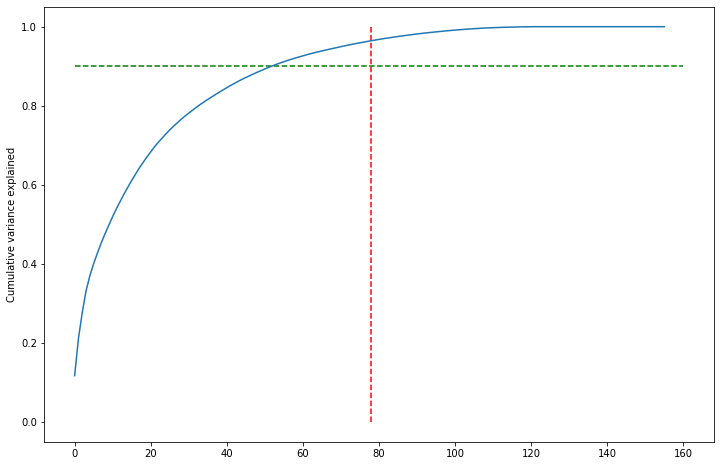

In [248]:
fig = plt.figure(figsize=[12,8])
plt.vlines(x=156/2, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.9, xmax=160, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

In [249]:
# Checking the exact number of variables 
len(var_cumu[var_cumu < 0.9])

52

In [250]:
# Since we can see that is a good reduction in the number of components, we can select pca = 0.9
pca_1 = PCA(0.9)

In [251]:
X_train_4 = pca_1.fit_transform(X_train_4)

In [252]:
X_train_4.shape

(20967, 53)

In [253]:
X_test_4 = pca_1.transform(X_test_4)

In [254]:
X_test_4.shape

(8986, 53)

# Logistic Regression

In [255]:
lr = LogisticRegression()

In [256]:
lr.fit(X_train_4,y_train_4)

LogisticRegression()

In [257]:
y_pred_lr = lr.predict(X_train_4)

In [258]:
print(classification_report(y_train_4,y_pred_lr))
confusion_matrix(y_train_4,y_pred_lr)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     19264
           1       0.67      0.24      0.35      1703

    accuracy                           0.93     20967
   macro avg       0.81      0.61      0.66     20967
weighted avg       0.91      0.93      0.91     20967



array([[19070,   194],
       [ 1301,   402]], dtype=int64)

In [259]:
y_test_4_pred_lr = lr.predict(X_test_4)

In [260]:
test_eval(lr, X_test_4, y_test_4, 'Logistic Regression',pca_YN = 'PCA')

Confusion Matrix
[[8145  111]
 [ 539  191]] 

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      8256
           1       0.63      0.26      0.37       730

    accuracy                           0.93      8986
   macro avg       0.79      0.62      0.67      8986
weighted avg       0.91      0.93      0.91      8986
 

AUC-ROC
0.8962917794945311


# Random forest

In [261]:
rf = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=7)

In [262]:
rf.fit(X_train_4, y_train_4)

RandomForestClassifier(max_depth=7, n_estimators=10, random_state=42)

In [263]:
y_train_4_pred_rf = rf.predict(X_train_4)

In [264]:
print(classification_report(y_train_4, y_train_4_pred_rf))
confusion_matrix(y_train_4, y_train_4_pred_rf)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     19264
           1       0.89      0.08      0.14      1703

    accuracy                           0.92     20967
   macro avg       0.91      0.54      0.55     20967
weighted avg       0.92      0.92      0.89     20967



array([[19248,    16],
       [ 1572,   131]], dtype=int64)

In [265]:
y_test_4_pred_rf = rf.predict(X_test_4)

In [266]:
test_eval(rf, X_test_4, y_test_4, 'Random Forest',pca_YN = 'PCA')

Confusion Matrix
[[8247    9]
 [ 707   23]] 

Classification Report
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      8256
           1       0.72      0.03      0.06       730

    accuracy                           0.92      8986
   macro avg       0.82      0.52      0.51      8986
weighted avg       0.90      0.92      0.89      8986
 

AUC-ROC
0.8561133621376233


In [267]:
rf4 = rf.feature_importances_

## RandomForestCV

In [268]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [269]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [ 2, 5],
    'min_samples_leaf': [2,5],
    'max_features': [5,8],
    'n_estimators': [5,10]
}

In [270]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=classifier_rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = metrics.make_scorer(metrics.recall_score))

In [271]:
%%time
grid_search.fit(X_train_4, y_train_4)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
Wall time: 2.98 s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 5], 'max_features': [5, 8],
                         'min_samples_leaf': [2, 5], 'n_estimators': [5, 10]},
             scoring=make_scorer(recall_score), verbose=1)

In [272]:
rfcv_best = grid_search.best_estimator_

In [273]:
rfcv_best

RandomForestClassifier(max_depth=5, max_features=8, min_samples_leaf=2,
                       n_estimators=5, n_jobs=-1, random_state=42)

In [274]:
y_train_4_pred_rfcv = rfcv_best.predict(X_train_4)

In [275]:
print(classification_report(y_train_4, y_train_4_pred_rfcv))
confusion_matrix(y_train_4, y_train_4_pred_rfcv)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     19264
           1       0.50      0.00      0.00      1703

    accuracy                           0.92     20967
   macro avg       0.71      0.50      0.48     20967
weighted avg       0.88      0.92      0.88     20967



array([[19263,     1],
       [ 1702,     1]], dtype=int64)

In [276]:
y_test_4_pred_rfcv = rfcv_best.predict(X_test_4)

In [277]:
test_eval(rfcv_best, X_test_4, y_test_4, 'Random Forest CV',pca_YN = 'PCA')

Confusion Matrix
[[8256    0]
 [ 729    1]] 

Classification Report
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      8256
           1       1.00      0.00      0.00       730

    accuracy                           0.92      8986
   macro avg       0.96      0.50      0.48      8986
weighted avg       0.93      0.92      0.88      8986
 

AUC-ROC
0.8404028286609324


In [278]:
rfcv4 = rfcv_best.feature_importances_

# XGB

In [279]:
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic',n_estimators = 100, gamma = 0.1, learning_rate = 0.05, 
                            max_depth = 5, min_child_weight= 7, subsample = 0.8 )
xgb_cfl.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': 0.1,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.05,
 'max_delta_step': None,
 'max_depth': 5,
 'min_child_weight': 7,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [280]:
# Fit the model to our train and target
xgb_cfl.fit(X_train_4, y_train_4)  # default 

[21:10:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [281]:
# Get our predictions
y_train_4_pred_xgb = xgb_cfl.predict(X_train_4)

In [282]:
print(classification_report(y_train_4, y_train_4_pred_xgb))
confusion_matrix(y_train_4, y_train_4_pred_xgb)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     19264
           1       0.84      0.37      0.51      1703

    accuracy                           0.94     20967
   macro avg       0.89      0.68      0.74     20967
weighted avg       0.94      0.94      0.93     20967



array([[19141,   123],
       [ 1079,   624]], dtype=int64)

In [283]:
# Get our predictions
y_test_4_pred_xgb = xgb_cfl.predict(X_test_4)

In [284]:
test_eval(xgb_cfl, X_test_4, y_test_4, 'XGB',pca_YN = 'PCA')

Confusion Matrix
[[8158   98]
 [ 553  177]] 

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      8256
           1       0.64      0.24      0.35       730

    accuracy                           0.93      8986
   macro avg       0.79      0.62      0.66      8986
weighted avg       0.91      0.93      0.91      8986
 

AUC-ROC
0.8961726465434853


In [285]:
xgb4 = xgb_cfl.feature_importances_

## XGB Gridsearch

In [286]:
# params = {'n_estimators' : [100, 200],
#         'learning_rate' : [0.1, 0.05],  # eta
#         'min_child_weight': [5,7],
#         'gamma': [0.1, 0.5],
#         'subsample': [0.6, 0.8],
#         'max_depth': [2,3]
#         }

# folds = 4

# param_comb = 600

# xgb_search = GridSearchCV(xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic'), param_grid=params, 
#                           cv=3, n_jobs=-1, verbose=1, scoring = metrics.make_scorer(metrics.recall_score))




In [287]:
# %%time
# xgb_search.fit(X_train_4, y_train_4)

In [288]:
# print('\n Best estimator:')
# print(xgb_search.best_estimator_)
# print('\n Best accuracy for %d-fold search with %d parameter combinations:' % (folds, param_comb))
# print(xgb_search.best_score_ )
# print('\n Best hyperparameters:')
# print(xgb_search.best_params_)

Best estimator:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

 Best accuracy for 4-fold search with 600 parameter combinations:
0.8417985172514113

 Best hyperparameters:
 
{'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 200, 'subsample': 0.6}

In [289]:
xgbcv_best = xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic',n_estimators = 200, gamma = 0.1, learning_rate = 0.1, 
                            max_depth = 3, min_child_weight= 7, subsample = 0.6 )
xgbcv_best.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': 0.1,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_delta_step': None,
 'max_depth': 3,
 'min_child_weight': 7,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 200,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': 0.6,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [290]:
# Fit the model to our train and target
xgbcv_best.fit(X_train_4, y_train_4)  # default 

[21:10:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [291]:
y_train_3_pred_xgbcv = xgbcv_best.predict(X_train_4)

In [292]:
y_train_4_pred_xgbcv = xgbcv_best.predict(X_train_4)

In [293]:
print(classification_report(y_train_4, y_train_4_pred_xgbcv))
confusion_matrix(y_train_4, y_train_4_pred_xgbcv)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     19264
           1       0.81      0.46      0.59      1703

    accuracy                           0.95     20967
   macro avg       0.88      0.73      0.78     20967
weighted avg       0.94      0.95      0.94     20967



array([[19079,   185],
       [  920,   783]], dtype=int64)

In [294]:
y_test_4_pred_xgbcv = xgbcv_best.predict(X_test_4)

In [295]:
test_eval(xgbcv_best, X_test_4, y_test_4, 'XGB CV',pca_YN = 'PCA')

Confusion Matrix
[[8120  136]
 [ 476  254]] 

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      8256
           1       0.65      0.35      0.45       730

    accuracy                           0.93      8986
   macro avg       0.80      0.67      0.71      8986
weighted avg       0.92      0.93      0.92      8986
 

AUC-ROC
0.9028729624615056


In [296]:
xgbcv4 = xgbcv_best.feature_importances_

# <font color = 'red'>Telecom Churn case study - SMOTE - PCA

In [297]:
X_train_5 = X_train.copy()

In [298]:
X_test_5 = X_test.copy()

In [299]:
y_train_5 = y_train.copy()

In [300]:
y_test_5 = y_test.copy()

# Handling class imbalance using SMOTE 

In [301]:
# from imblearn.over_sampling import SMOTE
# from collections import Counter

counter = Counter(y_train_5)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()

X_train_5, y_train_5 = smt.fit_resample(X_train_5, y_train_5)

counter = Counter(y_train_5)
print('After',counter)

Before Counter({0: 19264, 1: 1703})
After Counter({1: 19264, 0: 19264})


# PCA

In [302]:
# from sklearn.decomposition import PCA

In [303]:
pca = PCA(random_state=42)

In [304]:
pca.fit(X_train_5)

PCA(random_state=42)

#### Components from the PCA

In [305]:
pca.components_

array([[-7.41246222e-02, -5.91539564e-02, -1.95027256e-02, ...,
         1.23969295e-01,  9.24428686e-02,  1.03184900e-01],
       [ 1.61378885e-01,  2.00161137e-01,  1.93192729e-01, ...,
         4.09188717e-02,  1.02744516e-01,  1.07077358e-01],
       [ 7.60507673e-02,  7.33781784e-02,  2.11543997e-02, ...,
         1.08604873e-01,  1.22409844e-01,  1.40998703e-01],
       ...,
       [-0.00000000e+00,  5.80119178e-17, -1.05944705e-16, ...,
        -1.00799546e-01, -1.12027744e-01,  3.66004627e-01],
       [ 0.00000000e+00, -2.66224923e-16,  1.19840240e-16, ...,
         9.21566920e-02, -5.30290524e-02, -7.98212337e-02],
       [-0.00000000e+00, -2.20680051e-16, -7.99801069e-17, ...,
        -5.06543116e-02, -8.22644107e-02,  2.26490283e-01]])

Looking at the explained variance ratio for each component

In [306]:
a = pca.explained_variance_ratio_
a

array([1.18587754e-01, 9.12097082e-02, 6.21548803e-02, 5.81566849e-02,
       4.64576155e-02, 3.50628381e-02, 3.19450076e-02, 2.95601167e-02,
       2.42830472e-02, 2.34793978e-02, 2.06688333e-02, 1.94742380e-02,
       1.91814404e-02, 1.73538005e-02, 1.57672778e-02, 1.52128241e-02,
       1.48601277e-02, 1.35526558e-02, 1.32038239e-02, 1.22277087e-02,
       1.19460147e-02, 1.13922930e-02, 1.05871801e-02, 1.03503472e-02,
       9.97909417e-03, 9.42926959e-03, 9.30329438e-03, 8.70252187e-03,
       8.19563727e-03, 8.07351206e-03, 7.35490117e-03, 7.23496188e-03,
       7.13270477e-03, 6.97142605e-03, 6.76830748e-03, 6.39656890e-03,
       6.16199939e-03, 5.90524420e-03, 5.73480178e-03, 5.52616842e-03,
       5.47757772e-03, 5.41148205e-03, 5.29262151e-03, 5.02471738e-03,
       5.00133384e-03, 4.93003497e-03, 4.59979354e-03, 4.38159392e-03,
       4.26993733e-03, 4.21119998e-03, 4.10194965e-03, 3.81099007e-03,
       3.67983435e-03, 3.43132588e-03, 3.40067363e-03, 3.16241280e-03,
      

Making a scree plot for the explained variance

In [307]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

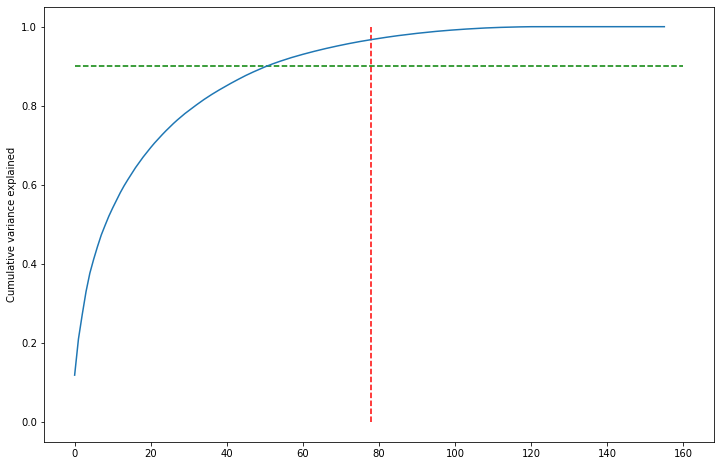

In [308]:
fig = plt.figure(figsize=[12,8])
plt.vlines(x=156/2, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.9, xmax=160, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

In [309]:
# Checking the exact number of variables 
len(var_cumu[var_cumu < 0.9])

51

In [310]:
# Since we can see that is a good reduction in the number of components, we can select pca = 0.9
pca_1 = PCA(0.9)

In [311]:
X_train_5 = pca_1.fit_transform(X_train_5)

In [312]:
X_train_5.shape

(38528, 52)

In [313]:
X_test_5 = pca_1.transform(X_test_5)

In [314]:
X_test_5.shape

(8986, 52)

# Logistic Regression

In [315]:
lr = LogisticRegression()

In [316]:
lr.fit(X_train_5,y_train_5)

LogisticRegression()

In [317]:
y_pred_lr = lr.predict(X_train_5)

In [318]:
print(classification_report(y_train_5,y_pred_lr))
confusion_matrix(y_train_5,y_pred_lr)

              precision    recall  f1-score   support

           0       0.85      0.82      0.84     19264
           1       0.83      0.86      0.84     19264

    accuracy                           0.84     38528
   macro avg       0.84      0.84      0.84     38528
weighted avg       0.84      0.84      0.84     38528



array([[15852,  3412],
       [ 2764, 16500]], dtype=int64)

In [319]:
y_test_5_pred_lr = lr.predict(X_test_5)

In [320]:
test_eval(lr, X_test_5, y_test_5, 'Logistic Regression', sampling='SMOTE',pca_YN = 'PCA')

Confusion Matrix
[[6741 1515]
 [ 119  611]] 

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.82      0.89      8256
           1       0.29      0.84      0.43       730

    accuracy                           0.82      8986
   macro avg       0.64      0.83      0.66      8986
weighted avg       0.93      0.82      0.85      8986
 

AUC-ROC
0.8955907534246577


# Random forest

In [321]:
rf = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=7)

In [322]:
rf.fit(X_train_5, y_train_5)

RandomForestClassifier(max_depth=7, n_estimators=10, random_state=42)

In [323]:
y_train_5_pred_rf = rf.predict(X_train_5)

In [324]:
print(classification_report(y_train_5, y_train_5_pred_rf))
confusion_matrix(y_train_5, y_train_5_pred_rf)

              precision    recall  f1-score   support

           0       0.85      0.86      0.86     19264
           1       0.86      0.85      0.86     19264

    accuracy                           0.86     38528
   macro avg       0.86      0.86      0.86     38528
weighted avg       0.86      0.86      0.86     38528



array([[16562,  2702],
       [ 2828, 16436]], dtype=int64)

In [325]:
y_test_5_pred_rf = rf.predict(X_test_5)

In [326]:
test_eval(rf, X_test_5, y_test_5, 'Random Forest', sampling='SMOTE',pca_YN = 'PCA')

Confusion Matrix
[[6971 1285]
 [ 200  530]] 

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      8256
           1       0.29      0.73      0.42       730

    accuracy                           0.83      8986
   macro avg       0.63      0.79      0.66      8986
weighted avg       0.92      0.83      0.86      8986
 

AUC-ROC
0.8665698504035257


In [327]:
rf5 = rf.feature_importances_

## RandomForestCV

In [328]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [329]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [7,10],
    'min_samples_leaf': [20],
    'n_estimators': [200,300]
}

In [330]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=classifier_rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = metrics.make_scorer(metrics.recall_score))

In [331]:
%%time
grid_search.fit(X_train_5, y_train_5)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Wall time: 1min 24s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [7, 10], 'min_samples_leaf': [20],
                         'n_estimators': [200, 300]},
             scoring=make_scorer(recall_score), verbose=1)

In [332]:
rfcv_best = grid_search.best_estimator_

In [333]:
rfcv_best

RandomForestClassifier(max_depth=10, min_samples_leaf=20, n_estimators=200,
                       n_jobs=-1, random_state=42)

In [334]:
y_train_5_pred_rfcv = rfcv_best.predict(X_train_5)

In [335]:
print(classification_report(y_train_5, y_train_5_pred_rfcv))
confusion_matrix(y_train_5, y_train_5_pred_rfcv)

              precision    recall  f1-score   support

           0       0.92      0.90      0.91     19264
           1       0.90      0.92      0.91     19264

    accuracy                           0.91     38528
   macro avg       0.91      0.91      0.91     38528
weighted avg       0.91      0.91      0.91     38528



array([[17325,  1939],
       [ 1518, 17746]], dtype=int64)

In [336]:
y_test_5_pred_rfcv = rfcv_best.predict(X_test_5)

In [337]:
test_eval(rfcv_best, X_test_5, y_test_5, 'Random Forest CV',sampling='SMOTE',pca_YN = 'PCA')

Confusion Matrix
[[7258  998]
 [ 187  543]] 

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      8256
           1       0.35      0.74      0.48       730

    accuracy                           0.87      8986
   macro avg       0.66      0.81      0.70      8986
weighted avg       0.92      0.87      0.89      8986
 

AUC-ROC
0.8863469987788043


In [338]:
rfcv5 = rfcv_best.feature_importances_

# XGB

In [339]:
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic',n_estimators = 150, gamma = 0.01, learning_rate = 0.3, 
                            max_depth = 4, min_child_weight= 3, subsample = 0.5 )
xgb_cfl.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': 0.01,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.3,
 'max_delta_step': None,
 'max_depth': 4,
 'min_child_weight': 3,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 150,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': 0.5,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [340]:
# Fit the model to our train and target
xgb_cfl.fit(X_train_5, y_train_5)  # default 

[21:12:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.01, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=4,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [341]:
# Get our predictions
y_train_5_pred_xgb = xgb_cfl.predict(X_train_5)

In [342]:
print(classification_report(y_train_5, y_train_5_pred_xgb))
confusion_matrix(y_train_5, y_train_5_pred_xgb)

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     19264
           1       0.93      0.97      0.95     19264

    accuracy                           0.95     38528
   macro avg       0.95      0.95      0.95     38528
weighted avg       0.95      0.95      0.95     38528



array([[17959,  1305],
       [  545, 18719]], dtype=int64)

In [343]:
# Get our predictions
y_test_5_pred_xgb = xgb_cfl.predict(X_test_5)

In [344]:
test_eval(xgb_cfl, X_test_5, y_test_5, 'XGB',sampling='SMOTE',pca_YN = 'PCA')

Confusion Matrix
[[7382  874]
 [ 217  513]] 

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      8256
           1       0.37      0.70      0.48       730

    accuracy                           0.88      8986
   macro avg       0.67      0.80      0.71      8986
weighted avg       0.92      0.88      0.89      8986
 

AUC-ROC
0.8799315732186471


In [345]:
xgb5 = xgb_cfl.feature_importances_

## XGB Gridsearch

In [346]:
# params = {'n_estimators' : [100, 200],
#         'learning_rate' : [0.1, 0.05],  # eta
#         'min_child_weight': [5,7],
#         'gamma': [0.1, 0.5],
#         'subsample': [0.6, 0.8],
#         'max_depth': [2,3]
#         }

# folds = 4

# param_comb = 600

# xgb_search = GridSearchCV(xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic'), param_grid=params, 
#                           cv=3, n_jobs=-1, verbose=1, scoring = metrics.make_scorer(metrics.recall_score))




In [347]:
# %%time
# xgb_search.fit(X_train_5, y_train_5)

In [348]:
# print('\n Best estimator:')
# print(xgb_search.best_estimator_)
# print('\n Best accuracy for %d-fold search with %d parameter combinations:' % (folds, param_comb))
# print(xgb_search.best_score_ )
# print('\n Best hyperparameters:')
# print(xgb_search.best_params_)

Best estimator:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

 Best accuracy for 4-fold search with 600 parameter combinations:
0.9775749042984524

 Best hyperparameters:
 
{'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 0.5}

In [349]:
xgbcv_best = xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic',n_estimators = 150, gamma = 0.1, learning_rate = 0.3, 
                            max_depth = 6, min_child_weight= 1, subsample = 0.5 )
xgbcv_best.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': 0.1,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.3,
 'max_delta_step': None,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 150,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': 0.5,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [350]:
# Fit the model to our train and target
xgbcv_best.fit(X_train_5, y_train_5)  # default 

[21:12:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [351]:
y_train_5_pred_xgbcv = xgbcv_best.predict(X_train_5)

In [352]:
print(classification_report(y_train_5, y_train_5_pred_xgbcv))
confusion_matrix(y_train_5, y_train_5_pred_xgbcv)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19264
           1       1.00      1.00      1.00     19264

    accuracy                           1.00     38528
   macro avg       1.00      1.00      1.00     38528
weighted avg       1.00      1.00      1.00     38528



array([[19197,    67],
       [    3, 19261]], dtype=int64)

In [353]:
y_test_5_pred_xgbcv = xgbcv_best.predict(X_test_5)

In [354]:
test_eval(xgbcv_best, X_test_5, y_test_5,'XGB CV',sampling='SMOTE',pca_YN = 'PCA')

Confusion Matrix
[[7664  592]
 [ 305  425]] 

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      8256
           1       0.42      0.58      0.49       730

    accuracy                           0.90      8986
   macro avg       0.69      0.76      0.72      8986
weighted avg       0.92      0.90      0.91      8986
 

AUC-ROC
0.8727026255707762


In [355]:
xgbcv5 = xgbcv_best.feature_importances_

# <font color ='red'>Telecom Churn case study - ADASYN - PCA

In [356]:
X_train_6 = X_train.copy()

In [357]:
X_test_6 = X_test.copy()

In [358]:
y_train_6 = y_train.copy()

In [359]:
y_test_6 = y_test.copy()

## Handling class imbalance using ADASYN 

In [360]:
# from imblearn.over_sampling import ADASYN
# from collections import Counter

counter = Counter(y_train_6)
print('Before',counter)
# oversampling the train dataset using SMOTE
adasyn = ADASYN()

X_train_6, y_train_6 = adasyn.fit_resample(X_train_6, y_train_6)

counter = Counter(y_train_6)
print('After',counter)

Before Counter({0: 19264, 1: 1703})
After Counter({1: 19652, 0: 19264})


## PCA

In [361]:
# from sklearn.decomposition import PCA

In [362]:
pca = PCA(random_state=42)

In [363]:
pca.fit(X_train_6)

PCA(random_state=42)

#### Components from the PCA

In [364]:
pca.components_

array([[-6.89768429e-02, -6.13126397e-02, -3.10061787e-02, ...,
         1.26715277e-01,  9.41269895e-02,  1.05476723e-01],
       [ 1.68067793e-01,  2.00083845e-01,  1.90191705e-01, ...,
         4.25223478e-02,  1.04043318e-01,  1.11510629e-01],
       [ 5.68602999e-02,  6.47980970e-02,  2.72811272e-02, ...,
         1.23689292e-01,  1.33531799e-01,  1.48658822e-01],
       ...,
       [-0.00000000e+00, -4.94686209e-17,  2.20167980e-16, ...,
        -3.37316576e-01,  4.13632819e-01, -6.76725741e-02],
       [-0.00000000e+00,  1.44930572e-16, -4.41407983e-16, ...,
        -1.03263302e-01,  1.65534397e-01, -8.44915213e-02],
       [-0.00000000e+00, -3.62981322e-17,  1.13143167e-16, ...,
        -1.00110807e-01,  1.29782862e-02,  1.59860287e-01]])

Looking at the explained variance ratio for each component

In [365]:
a = pca.explained_variance_ratio_
a

array([1.18938446e-01, 9.03434076e-02, 6.21644913e-02, 5.56987388e-02,
       4.40090874e-02, 3.96089425e-02, 3.28352559e-02, 3.05602076e-02,
       3.02906708e-02, 2.39495491e-02, 2.17902009e-02, 1.88432681e-02,
       1.83119405e-02, 1.73480385e-02, 1.60667648e-02, 1.52871750e-02,
       1.48978039e-02, 1.33602236e-02, 1.30607162e-02, 1.16088909e-02,
       1.06758151e-02, 1.05829405e-02, 1.04745060e-02, 9.94322254e-03,
       9.92810859e-03, 9.52430049e-03, 9.10407850e-03, 8.47768219e-03,
       8.17612078e-03, 8.05867709e-03, 7.77852212e-03, 7.12222206e-03,
       7.08447117e-03, 6.83594618e-03, 6.63299755e-03, 6.33443418e-03,
       6.07968758e-03, 5.74313125e-03, 5.63513754e-03, 5.47806749e-03,
       5.47777316e-03, 5.27806027e-03, 5.17492373e-03, 5.10134069e-03,
       4.89904297e-03, 4.78122292e-03, 4.51334936e-03, 4.42355311e-03,
       4.20278569e-03, 4.11858319e-03, 4.01851856e-03, 3.76871772e-03,
       3.72715383e-03, 3.40418323e-03, 3.34874901e-03, 3.10661188e-03,
      

Making a scree plot for the explained variance

In [366]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

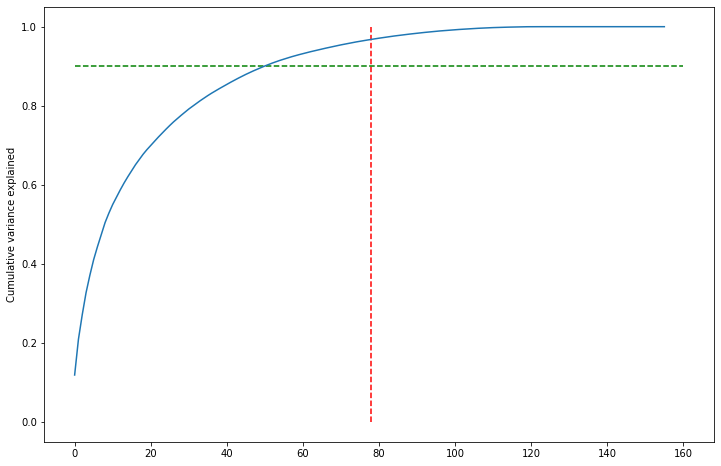

In [367]:
fig = plt.figure(figsize=[12,8])
plt.vlines(x=156/2, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.9, xmax=160, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

In [368]:
# Checking the exact number of variables 
len(var_cumu[var_cumu < 0.9])

50

In [369]:
# Since we can see that is a good reduction in the number of components, we can select pca = 0.9
pca_1 = PCA(0.9)

In [370]:
X_train_6 = pca_1.fit_transform(X_train_6)

In [371]:
X_train_6.shape

(38916, 51)

In [372]:
X_test_6 = pca_1.transform(X_test_6)

In [373]:
X_test_6.shape

(8986, 51)

## Logistic Regression

In [374]:
lr = LogisticRegression()

In [375]:
lr.fit(X_train_6,y_train_6)

LogisticRegression()

In [376]:
y_pred_lr = lr.predict(X_train_6)

In [377]:
print(classification_report(y_train_6,y_pred_lr))
confusion_matrix(y_train_6,y_pred_lr)

              precision    recall  f1-score   support

           0       0.83      0.79      0.81     19264
           1       0.80      0.84      0.82     19652

    accuracy                           0.81     38916
   macro avg       0.81      0.81      0.81     38916
weighted avg       0.81      0.81      0.81     38916



array([[15229,  4035],
       [ 3219, 16433]], dtype=int64)

In [378]:
y_test_6_pred_lr = lr.predict(X_test_6)

In [379]:
test_eval(lr, X_test_6, y_test_6, 'Logistic Regression', sampling='ADASYN',pca_YN = 'PCA')

Confusion Matrix
[[6470 1786]
 [ 105  625]] 

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      8256
           1       0.26      0.86      0.40       730

    accuracy                           0.79      8986
   macro avg       0.62      0.82      0.64      8986
weighted avg       0.93      0.79      0.83      8986
 

AUC-ROC
0.8949202572475309


## Random forest

In [380]:
rf = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=7)

In [381]:
rf.fit(X_train_6, y_train_6)

RandomForestClassifier(max_depth=7, n_estimators=10, random_state=42)

In [382]:
y_train_6_pred_rf = rf.predict(X_train_6)

In [383]:
print(classification_report(y_train_6, y_train_6_pred_rf))
confusion_matrix(y_train_6, y_train_6_pred_rf)

              precision    recall  f1-score   support

           0       0.86      0.82      0.84     19264
           1       0.83      0.87      0.85     19652

    accuracy                           0.84     38916
   macro avg       0.85      0.84      0.84     38916
weighted avg       0.85      0.84      0.84     38916



array([[15728,  3536],
       [ 2506, 17146]], dtype=int64)

In [384]:
y_test_6_pred_rf = rf.predict(X_test_6)

In [385]:
test_eval(rf, X_test_6, y_test_6, 'Random Forest', sampling='ADASYN',pca_YN = 'PCA')

Confusion Matrix
[[6620 1636]
 [ 155  575]] 

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.80      0.88      8256
           1       0.26      0.79      0.39       730

    accuracy                           0.80      8986
   macro avg       0.62      0.79      0.64      8986
weighted avg       0.92      0.80      0.84      8986
 

AUC-ROC
0.8632861447382394


In [386]:
rf6 = rf.feature_importances_

## RandomForestCV

In [387]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [388]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [7,10],
    'min_samples_leaf': [20],
    'n_estimators': [200,300]
}

In [389]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=classifier_rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = metrics.make_scorer(metrics.recall_score))

In [390]:
%%time
grid_search.fit(X_train_6, y_train_6)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Wall time: 1min 26s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [7, 10], 'min_samples_leaf': [20],
                         'n_estimators': [200, 300]},
             scoring=make_scorer(recall_score), verbose=1)

In [391]:
rfcv_best = grid_search.best_estimator_

In [392]:
rfcv_best

RandomForestClassifier(max_depth=10, min_samples_leaf=20, n_estimators=300,
                       n_jobs=-1, random_state=42)

In [393]:
y_train_6_pred_rfcv = rfcv_best.predict(X_train_6)

In [394]:
print(classification_report(y_train_6, y_train_6_pred_rfcv))
confusion_matrix(y_train_6, y_train_6_pred_rfcv)

              precision    recall  f1-score   support

           0       0.93      0.88      0.90     19264
           1       0.89      0.93      0.91     19652

    accuracy                           0.91     38916
   macro avg       0.91      0.91      0.91     38916
weighted avg       0.91      0.91      0.91     38916



array([[17028,  2236],
       [ 1350, 18302]], dtype=int64)

In [395]:
y_test_6_pred_rfcv = rfcv_best.predict(X_test_6)

In [396]:
test_eval(rfcv_best, X_test_6, y_test_6, 'Random Forest CV' ,sampling='ADASYN',pca_YN = 'PCA')

Confusion Matrix
[[7093 1163]
 [ 175  555]] 

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.86      0.91      8256
           1       0.32      0.76      0.45       730

    accuracy                           0.85      8986
   macro avg       0.65      0.81      0.68      8986
weighted avg       0.92      0.85      0.88      8986
 

AUC-ROC
0.8852487522565573


In [397]:
rfcv6 = rfcv_best.feature_importances_

## XGB

In [398]:
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic',n_estimators = 150, gamma = 0.01, learning_rate = 0.3, 
                            max_depth = 4, min_child_weight= 3, subsample = 0.5 )
xgb_cfl.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': 0.01,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.3,
 'max_delta_step': None,
 'max_depth': 4,
 'min_child_weight': 3,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 150,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': 0.5,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [399]:
# Fit the model to our train and target
xgb_cfl.fit(X_train_6, y_train_6)  # default 

[21:14:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.01, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=4,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [400]:
# Get our predictions
y_train_6_pred_xgb = xgb_cfl.predict(X_train_6)

In [401]:
print(classification_report(y_train_6, y_train_6_pred_xgb))
confusion_matrix(y_train_6, y_train_6_pred_xgb)

              precision    recall  f1-score   support

           0       0.97      0.92      0.95     19264
           1       0.93      0.98      0.95     19652

    accuracy                           0.95     38916
   macro avg       0.95      0.95      0.95     38916
weighted avg       0.95      0.95      0.95     38916



array([[17789,  1475],
       [  481, 19171]], dtype=int64)

In [402]:
# Get our predictions
y_test_6_pred_xgb = xgb_cfl.predict(X_test_6)

In [403]:
test_eval(xgb_cfl, X_test_6, y_test_6, 'XGB',sampling='ADASYN',pca_YN = 'PCA')

Confusion Matrix
[[7287  969]
 [ 215  515]] 

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      8256
           1       0.35      0.71      0.47       730

    accuracy                           0.87      8986
   macro avg       0.66      0.79      0.70      8986
weighted avg       0.92      0.87      0.89      8986
 

AUC-ROC
0.8706375438037591


In [404]:
xgb6 = xgb_cfl.feature_importances_

## XGB Gridsearch

XGB Gridsearch takes a longtime. So we already did it and is using the best parameters for prediction 

In [405]:
# params = {'n_estimators' : [100, 200],
#         'learning_rate' : [0.1, 0.05],  # eta
#         'min_child_weight': [5,7],
#         'gamma': [0.1, 0.5],
#         'subsample': [0.6, 0.8],
#         'max_depth': [2,3]
#         }

# folds = 4

# param_comb = 600

# xgb_search = GridSearchCV(xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic'), param_grid=params, 
#                           cv=3, n_jobs=-1, verbose=1, scoring = metrics.make_scorer(metrics.recall_score))


# %%time
# xgb_search.fit(X_train_6, y_train_6)

# print('\n Best estimator:')
# print(xgb_search.best_estimator_)
# print('\n Best accuracy for %d-fold search with %d parameter combinations:' % (folds, param_comb))
# print(xgb_search.best_score_ )
# print('\n Best hyperparameters:')
# print(xgb_search.best_params_)

Best estimator:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

 Best accuracy for 4-fold search with 600 parameter combinations:
0.8930401861611944

 Best hyperparameters:
 
{'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 0.5}
​

In [406]:
xgbcv_best = xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic',n_estimators = 150, gamma = 0.1, learning_rate = 0.3, 
                            max_depth = 6, min_child_weight= 1, subsample = 0.5 )
xgbcv_best.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': 0.1,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.3,
 'max_delta_step': None,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 150,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': 0.5,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [407]:
# Fit the model to our train and target
xgbcv_best.fit(X_train_6, y_train_6)  # default 

[21:14:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [408]:
y_train_6_pred_xgbcv = xgbcv_best.predict(X_train_6)

In [409]:
print(classification_report(y_train_6, y_train_6_pred_xgbcv))
confusion_matrix(y_train_6, y_train_6_pred_xgbcv)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     19264
           1       0.99      1.00      1.00     19652

    accuracy                           1.00     38916
   macro avg       1.00      1.00      1.00     38916
weighted avg       1.00      1.00      1.00     38916



array([[19162,   102],
       [    4, 19648]], dtype=int64)

In [410]:
y_test_6_pred_xgbcv = xgbcv_best.predict(X_test_6)

In [411]:
test_eval(xgbcv_best, X_test_6, y_test_6, 'XGB CV',sampling='ADASYN',pca_YN = 'PCA')

Confusion Matrix
[[7635  621]
 [ 287  443]] 

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      8256
           1       0.42      0.61      0.49       730

    accuracy                           0.90      8986
   macro avg       0.69      0.77      0.72      8986
weighted avg       0.92      0.90      0.91      8986
 

AUC-ROC
0.8691882035149199


In [412]:
xgbcv6 = xgbcv_best.feature_importances_

# Model Comparision

In [413]:
# Dataframe for model comparison
clf_eval_df = pd.DataFrame({'Model':model,
                            'Resample':resample,
                            'Dim Reduction':PCA_YN, # Dimensionality reduction
                            'Accuracy': np.around(accuracy,2),
                            'Precision':np.around(precision,2),
                            'Recall':np.around(recall,2),
                            'F1-score':np.around(F1score,2),
                            'AUC-ROC':np.around(AUCROC,2)})

In [414]:
clf_eval_df

,Model,Resample,Dim Reduction,Accuracy,Precision,Recall,F1-score,AUC-ROC
0,LogisticRegression,No,RFECV-Recall,0.93,0.65,0.28,0.40,0.90
1,Random Forest,No,No,0.95,0.73,0.52,0.61,0.92
2,Random Forest CV,No,No,0.95,0.75,0.49,0.59,0.91
3,XGB,No,No,0.95,0.72,0.57,0.64,0.94
4,XGB CV,No,No,0.94,0.70,0.56,0.62,0.94
5,LogisticRegression,SMOTE,RFECV,0.82,0.29,0.83,0.43,0.89
6,Random Forest,SMOTE,No,0.90,0.44,0.77,0.56,0.92
7,Random Forest CV,SMOTE,No,0.87,0.37,0.78,0.50,0.90
8,XGB,SMOTE,No,0.92,0.49,0.75,0.59,0.93
9,XGB CV,SMOTE,No,0.93,0.54,0.70,0.61,0.92


In [415]:
clf_eval_df.sort_values(by='F1-score',ascending = False )

,Model,Resample,Dim Reduction,Accuracy,Precision,Recall,F1-score,AUC-ROC
3,XGB,No,No,0.95,0.72,0.57,0.64,0.94
4,XGB CV,No,No,0.94,0.70,0.56,0.62,0.94
1,Random Forest,No,No,0.95,0.73,0.52,0.61,0.92
9,XGB CV,SMOTE,No,0.93,0.54,0.70,0.61,0.92
14,XGB CV,ADASYN,No,0.92,0.53,0.69,0.60,0.92
2,Random Forest CV,No,No,0.95,0.75,0.49,0.59,0.91
8,XGB,SMOTE,No,0.92,0.49,0.75,0.59,0.93
13,XGB,ADASYN,No,0.91,0.46,0.76,0.58,0.93
6,Random Forest,SMOTE,No,0.90,0.44,0.77,0.56,0.92
11,Random Forest,ADASYN,No,0.89,0.40,0.78,0.53,0.92


From the list above, we will be choosing the following model:

<font color='Red'>model 9 :XGB model with SMOTE and no dimensionality reduction as given below 

In [416]:
clf_eval_df[(clf_eval_df.Recall == 0.70) & (clf_eval_df['F1-score'] == 0.61)]

,Model,Resample,Dim Reduction,Accuracy,Precision,Recall,F1-score,AUC-ROC
9,XGB CV,SMOTE,No,0.93,0.54,0.7,0.61,0.92


This model was chosen due to the following reasons :

1) It is having really good Recall value (0.7) which makes sure that almost 70% of the churn values are predicted correctly 

2) It is also having a good Precision value (0.54) which makes sure that out of all the predicted churned customers, the majority are actually going to churn. It also reduces the money the company has to spend on false postive customers 

In [417]:
# Finding the top 10 important features of this model 
y = xgbcv2
x = X_train_2.columns.values

q = pd.DataFrame({'Feature':x,
                'Importance':y})
qw = q.sort_values(by='Importance',ascending=False).head(10)

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

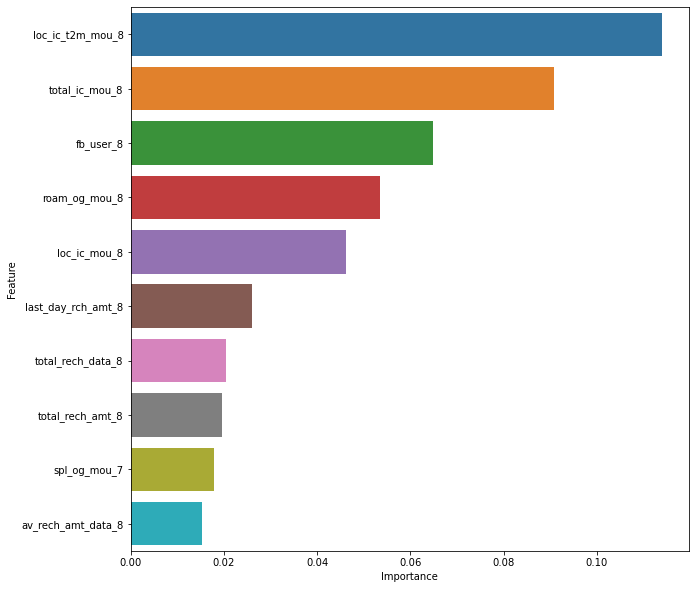

In [418]:
plt.figure(figsize=[10,10])
sns.barplot(y=qw.Feature,x=qw.Importance)

In [419]:
col_imp = list(qw.Feature)

In [420]:
col_imp.append('Churn')

In [424]:
df_init[col_imp].corr()['Churn']

loc_ic_t2m_mou_8     -0.160949
total_ic_mou_8       -0.178178
fb_user_8            -0.198992
roam_og_mou_8         0.067642
loc_ic_mou_8         -0.172209
last_day_rch_amt_8   -0.116054
total_rech_data_8    -0.119694
total_rech_amt_8     -0.160967
spl_og_mou_7          0.003256
av_rech_amt_data_8   -0.137253
Churn                 1.000000
Name: Churn, dtype: float64

In [426]:
df['last_day_rch_amt_8'].describe()

count    29953.000000
mean        92.443061
std        145.247315
min          0.000000
25%          0.000000
50%         50.000000
75%        130.000000
max       4449.000000
Name: last_day_rch_amt_8, dtype: float64

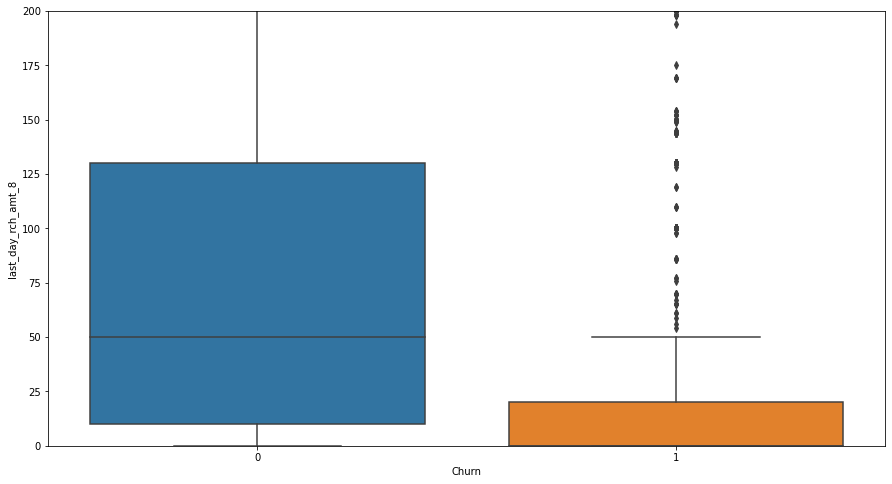

In [428]:
figure(figsize=(15, 8))
sns.boxplot(data=df_init, x='Churn', y='last_day_rch_amt_8').set_ylim([0, 200])
plt.show()

We can see that the parameters of the 8th month/'action' face played the major role in prediction

We can see that the parameters of the 8th month/'action' phase played the major role in prediction. In the action phase (8th month)
- the lesser incoming MOU for the customer the more likely they are to churn.
- not subscribing to service packs for SNS indicates higher liklihood for churn.
- the more MOU in outgoing while user is in roaming the higher liklihood for churn.
- the lesser the last recharge amount, the more likely the customer is to churn.
- the lesser the total recharge amount (including data recharge) higher liklihood for churn.

### Business Recommendations:

- Ask a customer representative to get feedback from the customer about their experience, if there is low incoming MOU for 8th month.
- Give lucrative offers for SNS service packs if the customer hasn't subscribed to any service packs for SNS in the 8th month.
- If customer has high outgoing calls in roaming for the 8th month, then give them offers for switching within the same network to their roaming telecom circle.
- Give attractive combo offers for calling and data if there is low recharge amount in the 8th month.